## Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургическому комбинату необходимо уменьшить потребление электроэнергии на этапе обработки стали, для этого необходимо построить модель, которая будет предсказывать температуру стали.

В нашем распоряжении находилось несколько наборов данных:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

В рамках решения поставленной задачи, помимо работы с данными и обучения модели, необходимо было подготовить отчет для бизнеса, текст которого приведет в конце настоящего ноутбука.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScalersns
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Загрузка данных

Для корректной загрузки данных как на локальной машине, так и на сервере будем использовать конструкцию `try-except`, в которой будем обрабатывать исключение `FileNotFoundError`. Сразу же переведем столбцы с датами в необходимый формат. 

In [2]:
try:
    data_arc = pd.read_csv('data_arc.csv', parse_dates=[1, 2])
except FileNotFoundError:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1, 2])

In [3]:
try:
    data_bulk = pd.read_csv('data_bulk.csv')
except FileNotFoundError:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [5]:
try:
    data_gas = pd.read_csv('data_gas.csv')
except FileNotFoundError:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [6]:
try:
    data_temp = pd.read_csv('data_temp.csv', parse_dates=[1])
except FileNotFoundError:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])

In [7]:
try:
    data_wire = pd.read_csv('data_wire.csv')
except FileNotFoundError:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

| [Импорт библиотек](#Импорт-библиотек)  |  [Загрузка данных](#Загрузка-данных)  |  [Исследовательский анализ данных](#Исследовательский-анализ-данных)
| [Обучение модели](#Обучение-модели)  |

## Исследовательский анализ данных

### Данные об электродах

In [9]:
data_arc.head(15)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0     1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.976059   
1     1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.805607   
2     1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.744363   
3     1  2019-05-03 11:18:14 2019-05-03 11:24:19           1.659363   
4     1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.692755   
5     2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.438063   
6     2  2019-05-03 11:38:50 2019-05-03 11:44:28           1.296415   
7     2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.490377   
8     2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.827743   
9     3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.062053   
10    3  2019-05-03 12:13:52 2019-05-03 12:15:56           0.484206   
11    3  2019-05-03 12:18:56 2019-05-03 12:20:45           0.429355   
12    3  2019-05-03 12:25:43 2019-05-03 12:27:00           0.299989   
13    3  2019-05-03 12:31:14 2019-05-03 12:32:19           0.250280   
14    4  2019-05-03 12:39:37 2019-05-03 12:43:04           0.875313   

    Реактивная мощность  
0              0.687084  
1              0.520285  
2              0.498805  
3              1.062669  
4              0.414397  
5              0.283043  
6              0.892914  
7              0.305281  
8              0.516874  
9              0.671494  
10             0.312100  
11             0.271774  
12             0.187806  
13             0.155901  
14             0.614404

Переименуем столбцы путем перевода их на английский язык, а также приведя название к стилю `lower_case_with_underscores`.

In [10]:
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_finish', 'active_power', 'reactive_power']

In [11]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


В рассматриваемом датафрейме 5 столбцов, каждый из которых содержит по 14876 записей, пропусков в данных нет. Формат данных указывает на то, что даты были преобразованы корректно. Посмотрим сколько у нас уникальных записей, а также период времени, с которым будем работать.

In [12]:
print('Датафрейм содержит информацию об обработке {} ковшей с металлом за период с {} по {}'
      .format(data_arc['key'].nunique(),
              data_arc['arc_heating_start'].min().date(), 
              data_arc['arc_heating_finish'].max().date()))

Датафрейм содержит информацию об обработке 3214 ковшей с металлом за период с 2019-05-03 по 2019-09-01


In [13]:
data_arc.duplicated(keep=False).value_counts()

False    14876
dtype: int64

Дубликатов записей в наборе данных нет.

In [14]:
data_arc.describe()

key  active_power  reactive_power
count  14876.000000  14876.000000    14876.000000
mean    1615.220422      0.670441        0.452592
std      934.571502      0.408159        5.878702
min        1.000000      0.030002     -715.504924
25%      806.000000      0.395297        0.290991
50%     1617.000000      0.555517        0.415962
75%     2429.000000      0.857034        0.637371
max     3241.000000      3.731596        2.676388

Среднее значение столбца `active_power` находится правее, чем медиана, что говорит о скошенности данных и, возможно, о наличии выбросов. Аналогичная картина у нас со столбцом `reactive_power`, только дополнительно выбивается отрицательное значение, порядок которого к тому же значительно отличается от остальных данных по датафрейму. Для начала посмотрим на то, сколько всего отрицательных значений в наборе данных.

In [15]:
data_arc.query('reactive_power < 0')

key   arc_heating_start  arc_heating_finish  active_power  \
9780  2116 2019-07-24 00:44:48 2019-07-24 00:46:37      0.495782   

      reactive_power  
9780     -715.504924

Как и предполагалось, данная запись единственная, ввиду чего точно является выбросом. Данные по ковшу 2116 стоить удалить. Создадим список ковшей для удаления, который будем наполнять по мере анализа данных. 

In [16]:
keys_to_delete = []
keys_to_delete.append(data_arc.query('reactive_power < 0')['key'].unique()[0])
keys_to_delete

[2116]

In [17]:
data_arc = data_arc.query('key not in @keys_to_delete')

Займемся визуализацией данных, для чего объявим функцию `hist_plotter`, которая будет принимать в качестве аргументов датафрейм, список столбцов по которым требуется построение гистграмм. Диапазон значений, количество корзин, а также тип гистограммы зададим по умолчанию с возможностью изменения при вызове функции. 

In [18]:
def hist_plotter(df, columns, values_range=(0, 5), bins=100, histtype='step'):
    plt.figure(figsize=(12, 9), dpi= 75)
    for i in range(len(columns)):
        plt.hist(df[columns[i]], bins=bins, label=columns[i], range=values_range, histtype=histtype)
    plt.legend(loc='upper left')
    plt.show()

Вызовем получившуюся функцию для столбцов `active_power`, `reactive_power`, передав аргументу values_range кортеж от -1 до максимального значения столбца `active_power` (т.к. его значение выше, чем у `reactive_power`), округленного до ближайшего следущего целого числа.

In [19]:
hist_plotter(data_arc, ['active_power', 'reactive_power'], 
        values_range=(-1, np.ceil(data_arc['active_power'].describe()['max'])))

Как и предполагалось, данные в обоих столбцах скошенны вправо, тянутся достаточно длинные хвосты. После значения 2 записей становится существенно меньше. Далее посмотрим на ящик с усами, для построения которого также будем использовать функцию, похожую на ранее объявленную для построения гистограмм.

In [20]:
def box_plotter(df, columns, values_range=(0, 5)):
    bottom, top = values_range
    plt.figure(figsize=(12, 9), dpi=75)
    sns.boxplot(data=df[columns], palette='hls')
    plt.ylim(bottom, top)
    plt.show()

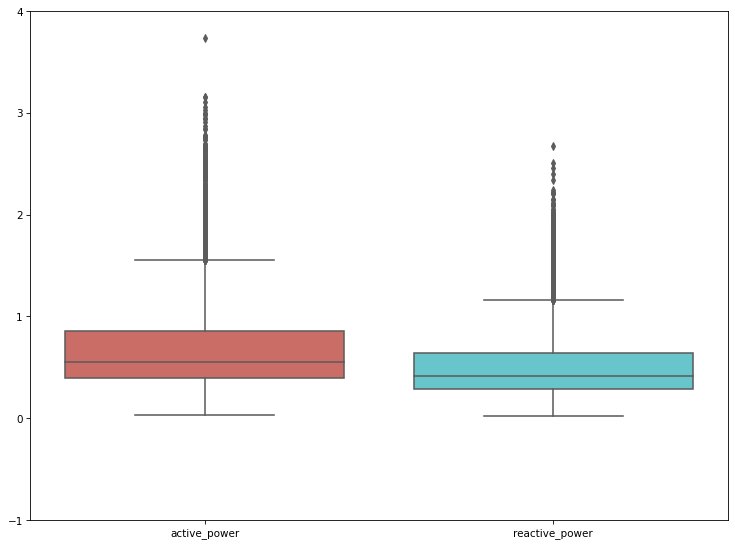

In [21]:
box_plotter(data_arc, ['active_power', 'reactive_power'], 
            values_range=(-1, np.ceil(data_arc['active_power'].describe()['max'])))

На графике видно достаточно много выбросов, которые имело бы смысл обособить и пообщаться с представителями заказчика по поводу причины их возникновения. Удалим только те значения, которые сильно выбивается из череды прочих выбросов. 

In [22]:
data_arc[(data_arc['active_power'] > 3.5) | 
         (data_arc['reactive_power'] == data_arc['reactive_power'].max())]

key   arc_heating_start  arc_heating_finish  active_power  \
7799  1689 2019-07-02 18:49:03 2019-07-02 19:04:10      3.731596   

      reactive_power  
7799        2.676388

Примечательно, что максимальному значению столбца `active_power` соответствует максимальное значение столбца `reactive_power`, что может быть обусловлено высокой корреляции данных столбцов. Так как у нас нет 100% понимания того, являются ли выбросами указанные значения, то мы вынесем номера ковшей с подозрительными значениями в отдельный список подозрительных ковшей, которые мы будем удалять только из обучающей выборки.

In [23]:
suspicious_keys = []
suspicious_keys.append(data_arc.query('active_power > 3.5')['key'].unique()[0])
suspicious_keys

[1689]

Посмотрим на корреляции между столбцами, объявив еще одну функцию.

In [24]:
def heatmap_plotter(df, figure_size=(12, 9), dots_per_inch=75):
    plt.figure(figsize=figure_size, dpi=dots_per_inch)
    sns.heatmap(df.corr(), 
            xticklabels=df.corr().columns, 
            yticklabels=df.corr().columns, 
            cmap='RdYlGn', center=0, annot=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

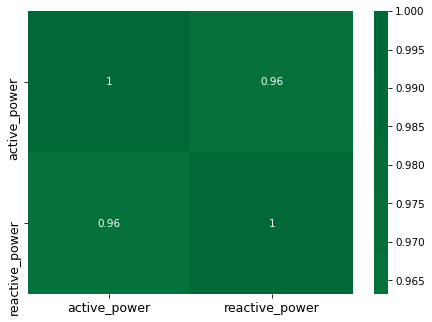

In [25]:
heatmap_plotter(data_arc.drop(labels='key', axis=1), figure_size=(7, 5))

Наше предположение о том, что между показателями `active_power` и `reactive_power` очень высокая корреляция подтвердилось.

В дальнейшем нам понадобится предсказать температуру стали, ввиду чего нам необходимы агрегированные данные по каждому из ковшей, то создадим новый датафрейм руководствуясь принципом "одна строка - один ковш". Выбемер несколько агрегирующих функций, чтобы добавить признаков нашей модели.

In [26]:
data_arc_agg = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'],
                                    aggfunc=['sum', 'mean', 'count'])
data_arc_agg.reset_index(inplace=True)
data_arc_agg.head()

key          sum                        mean                       count  \
      active_power reactive_power active_power reactive_power active_power   
0   1     4.878147       3.183241     0.975629       0.636648            5   
1   2     3.052598       1.998112     0.763150       0.499528            4   
2   3     2.525882       1.599076     0.505176       0.319815            5   
3   4     3.209250       2.060298     0.802313       0.515074            4   
4   5     3.347173       2.252643     0.836793       0.563161            4   

                  
  reactive_power  
0              5  
1              4  
2              5  
3              4  
4              4

Переименуем столбцы, чтобы избавиться от мульти-индексов.

In [27]:
data_arc_agg.columns = ['key',
                        'active_power_sum', 'reactive_power_sum', 
                        'active_power_mean', 'reactive_power_mean',
                        'active_power_count', 'reactive_power_count']
data_arc_agg.head()

key  active_power_sum  reactive_power_sum  active_power_mean  \
0    1          4.878147            3.183241           0.975629   
1    2          3.052598            1.998112           0.763150   
2    3          2.525882            1.599076           0.505176   
3    4          3.209250            2.060298           0.802313   
4    5          3.347173            2.252643           0.836793   

   reactive_power_mean  active_power_count  reactive_power_count  
0             0.636648                   5                     5  
1             0.499528                   4                     4  
2             0.319815                   5                     5  
3             0.515074                   4                     4  
4             0.563161                   4                     4

Набор данных data_arc_agg готов для дальнейшего использования.

### Данные о подаче сыпучих материалов (объем)

In [28]:
data_bulk.head(15)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0     1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1     2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2     3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3     4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4     5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5     6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6     7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7     8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8     9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9    10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10   11     NaN     NaN     NaN    69.0     NaN     NaN     NaN     NaN   
11   12    46.0     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
12   13     NaN     NaN     NaN     NaN     NaN    72.0     NaN     NaN   
13   14     NaN     NaN    71.0     NaN     NaN     NaN     NaN     NaN   
14   15     NaN     NaN     NaN     NaN     NaN    77.0     NaN     NaN   

    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0      NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1      NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2      NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3      NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4      NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5      NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6      NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7      NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8      NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9      NaN      NaN      NaN    203.0      NaN    102.0    204.0  
10     NaN      NaN      NaN    207.0      NaN    101.0    202.0  
11     NaN      NaN      NaN    618.0      NaN    406.0    203.0  
12     NaN      NaN      NaN    410.0      NaN    151.0    204.0  
13     NaN      NaN      NaN    204.0      NaN    152.0    203.0  
14     NaN      NaN      NaN      NaN      NaN    251.0    203.0

Переименуем столбцы по аналогии с предыдущим подразделом.

In [29]:
data_bulk.columns = ','.join(data_bulk.columns.to_list()).replace(' ', '_').lower().split(',')
data_bulk.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [30]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В датафрейме `data_bulk` содержатся данные типов int и float. Количество строк в столбце `key` чуть меньше, чем в предыдущем датафрейме, что может быть связано с наличием ковшей, по которым сыпучие материалы не добавлялись. В глаза также бросается большое количество пропусков, что опять же свидетельствует о использовании некоторых добавок в редких случаях. Посмотрим более внимательно на пропуски c помощью отдельного набора данных, полученого с помощью следующей функции.

In [31]:
def missing_values_table(df):
        # Количество пропущенных значений
        mis_val = df.isna().sum()
        
        # Процентное соотношение пропущенных значений
        mis_val_percent = 100 * df.isna().sum() / len(df)
        
        # Создание датафрейма из полученных данных
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Отсутствующие значения', 1 : '% от общего количества значений'})
        
        # Фильтрация и сортировка полученного датафрейма
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от общего количества значений', ascending=False).round(1)
        
        return mis_val_table_ren_columns

In [32]:
missing_values_table(data_bulk)

Отсутствующие значения  % от общего количества значений
bulk_8                     3128                            100.0
bulk_13                    3111                             99.4
bulk_9                     3110                             99.4
bulk_2                     3107                             99.3
bulk_7                     3104                             99.2
bulk_5                     3052                             97.5
bulk_10                    2953                             94.4
bulk_11                    2952                             94.3
bulk_1                     2877                             91.9
bulk_6                     2553                             81.6
bulk_4                     2115                             67.6
bulk_3                     1831                             58.5
bulk_15                     881                             28.2
bulk_12                     679                             21.7
bulk_14                     323                             10.3

Примечательно, что по 9 позициям из 15 пропусков более 90% (по позиции bulk_8 вообще 100%, но это может быть связано с округлением).

In [33]:
data_bulk.duplicated(keep=False).value_counts()

False    3129
dtype: int64

Дубликатов записей в наборе данных нет.

In [34]:
data_bulk.describe()

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          bulk_11      bulk_12     bulk_13      bulk_14      bulk_15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Одну из самых частоиспользуемых добавок (bulk_12) добавляют в среднем практически в самом большом количестве - больше добавляют только bulk_7, но это случалось всего 25 раз. bulk_8 использовали лишь единожды. 

Посмотрим на гистограммы, разбив данные на подгруппы для облегчения чтения графика.

In [35]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[1:4], bins=30, values_range=(-1, 460))

Данные до столбцам bulk_1, bulk_2 и bulk_3 распределены не нормально, имеется множество пиков на различных значениях, кроме того, все данные скошены вправо, прослеживаются значения, похожие на выбросы, но они не выглядят критичными. 

In [36]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[4:7], bins=30, values_range=(-1, 610))

Распределение данных в колонках bulk_4, bulk_5 и bulk_6 чуть более нормальное, чем в предыдущем примере, однако также наличествует скос данных, а также более ярко выраженные выбросы, особенно по столбцу bulk_5.

In [37]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[7:10], bins=30, values_range=(-1, 780))

Данные столбцов bulk_8 и bulk_9 сосредоточены в диапазоне до 150. Данные столбца bulk_7 распределены до значения около 780, при этом наблюдается большое количество гэпов и примерно одинаковая плотность на всем диапазоне значений.  

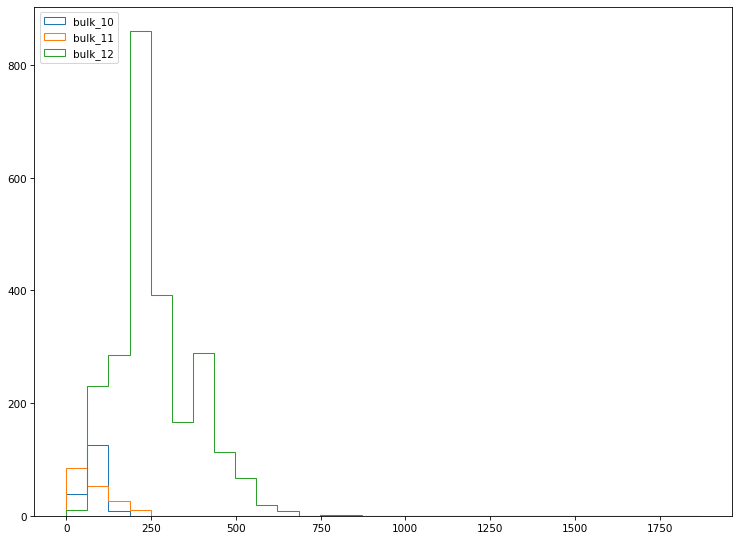

In [38]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[10:13], bins=30, values_range=(-1, 1870))

Данные в столбцах bulk_10, bulk_11 и bulk_12 выглядят достаточно аккуратно. В глаза бросается второй пик в столбце bulk_12, а также легкая скошенность этого столбца. Кроме того, в этом столбце содержится выброс на уровне 1849, который даже не виден на графике из-за одиночность такого показателя. Целесообразно удалить этот ковш.

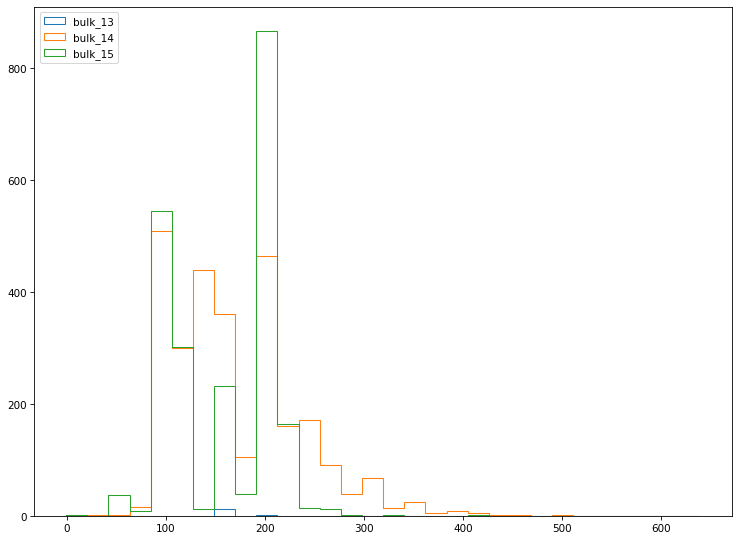

In [39]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[13:], bins=30, values_range=(-1, 640))

В столбцах bulk_13, bulk_14 и bulk_15 также царит хаос. В столбце есть похожее на выброс значение на уровне 630, но оно не сильно выделяется на фоне остальных значений этого столбца, пока не будем тут ничего трогать.

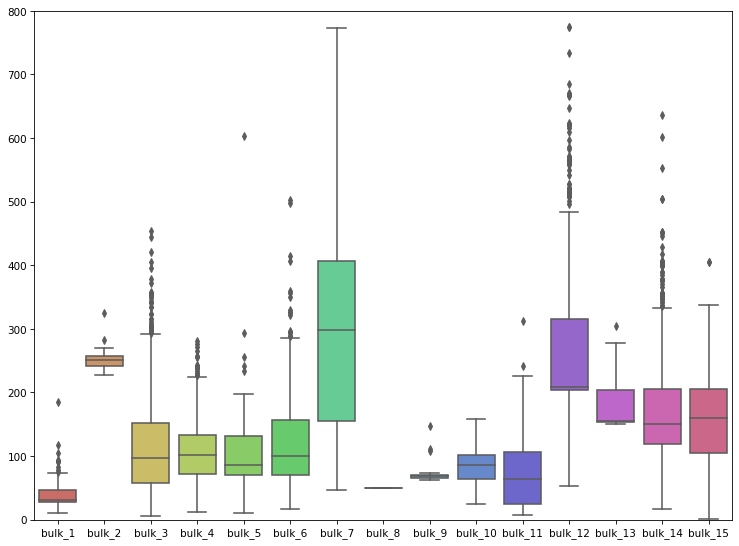

In [40]:
box_plotter(data_bulk, data_bulk.columns.to_list()[1:], 
            values_range=(-1, 800))

Вынесем номера ковшей с аномальными значениями в список подозрительных ковшей. Пометим выбросы из столбцов bulk_5 и bulk_12 (по последнему столбцу выброса не видно на графике из-за ограничений диапазона). По bulk_7 выбросов нет, не смотря на большой интервал межквартильного размаха. Это обусловлено самым высоким стандартным отклонением из всех столбцов, присутствующих в наборе данных data_bulk, что достаточно отчетливо видно и на гистограмме, и на ящике с усами.

In [41]:
for i in data_bulk[(data_bulk['bulk_5'] > 500) | (data_bulk['bulk_12'] > 1800)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808]

Заполним оставшиеся пропуски нулями, после чего посмотрим на наличие корреляций между добавками.

In [42]:
data_bulk.fillna(0, inplace=True)

In [43]:
heatmap_plotter(data_bulk.drop(labels='key', axis=1))

Чаще всего "в паре" работают добавки bulk_2 и bulk_7, bulk_12 и bulk_15, bulk_8 и bulk_9 (но это не очень показательно из-за редкого использования обеих добавок). Реже всего вместе используют добавки bulk_3 и bulk_4, bulk_4 и bulk_6.

### Данные о проволочных материалах (объемы)

In [45]:
data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

Переименуем названия столбцов.

In [46]:
data_wire.columns = ','.join(data_wire.columns.to_list()).replace(' ', '_').lower().split(',')
data_wire.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [47]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


По проволочным материалам ситуация похожа на ранее описанную: некоторые добавки используются почти в 100% случаев, некоторые же носят единичный характер, возможно, обусловленный подготовкой спец.марок сталей. 

In [48]:
missing_values_table(data_wire)

Отсутствующие значения  % от общего количества значений
wire_5                    3080                            100.0
wire_7                    3070                             99.6
wire_4                    3067                             99.5
wire_8                    3062                             99.4
wire_9                    3052                             99.1
wire_3                    3018                             98.0
wire_6                    3008                             97.6
wire_2                    2002                             65.0
wire_1                      26                              0.8

100% пропусков в столбце wire_5 связано с округлением, но разница между добавками действительно колоссальная.

In [49]:
data_wire.duplicated(keep=False).value_counts()

False    3081
dtype: int64

Дубликатов в наборе данных `data_wire` нет.

In [50]:
data_wire.describe()

key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           wire_6     wire_7      wire_8     wire_9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

На первый взгляд данные не содержат каких-то аномальных начений. По всем столбцам налбюдается некоторая скошенность, в основном, в правую сторону. Посмотрим на гистограммы.

In [51]:
hist_plotter(data_wire, data_wire.columns.to_list()[1:4], bins=20, 
             values_range=(-1, np.ceil(data_wire['wire_3'].describe()['max'])))

wire_1 и wire_2 имеют длинные хвосты вправо, что также было видно из ранее изученной таблицы. wire_3 имеет хаотичное распределение с большими гэпами и примерно одинаковым нполнением на каждом из участков гистограммы. Также на гистограмме видны несколько выбросов, но лучше их изучить на ящике с усами.

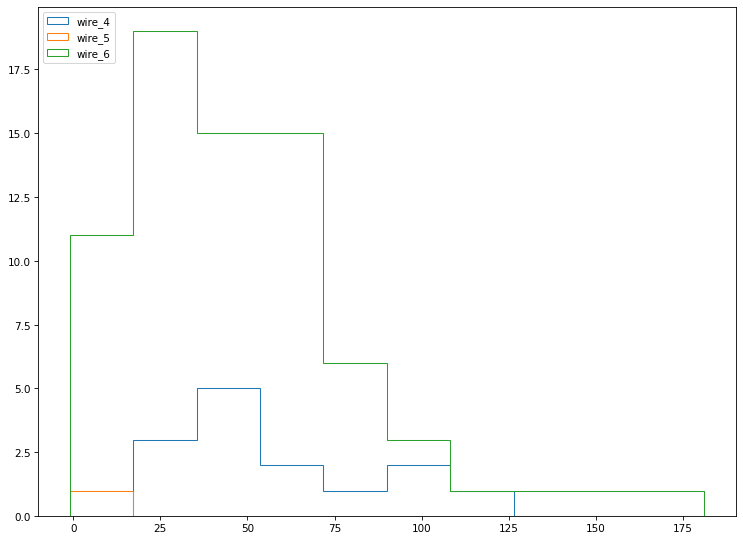

In [52]:
hist_plotter(data_wire, data_wire.columns.to_list()[4:7], bins=10, 
             values_range=(-1, np.ceil(data_wire['wire_6'].describe()['max'])))

В wire_4, wire_5 и wire_6 также нет нормального распределения. wire_6 имеет явный скос вправо, wire_4 вдобавок к хвосту имеет второй пик. wire_5 представлено в наборе данных 1 раз.

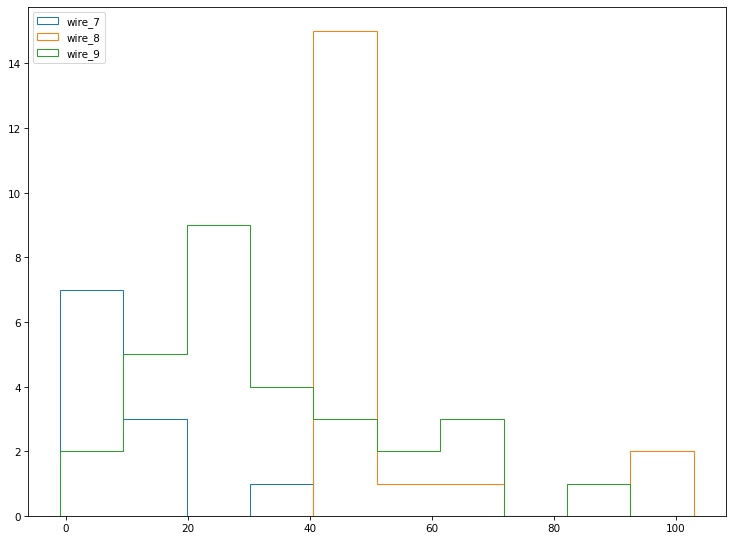

In [53]:
hist_plotter(data_wire, data_wire.columns.to_list()[7:10], bins=10, 
             values_range=(-1, np.ceil(data_wire['wire_8'].describe()['max'])))

Здесь ситуация аналогичная ранее описанным. В целом, все объясняется малым количетсвом записей во всех столбцах, кроме wire_1 и wire_2

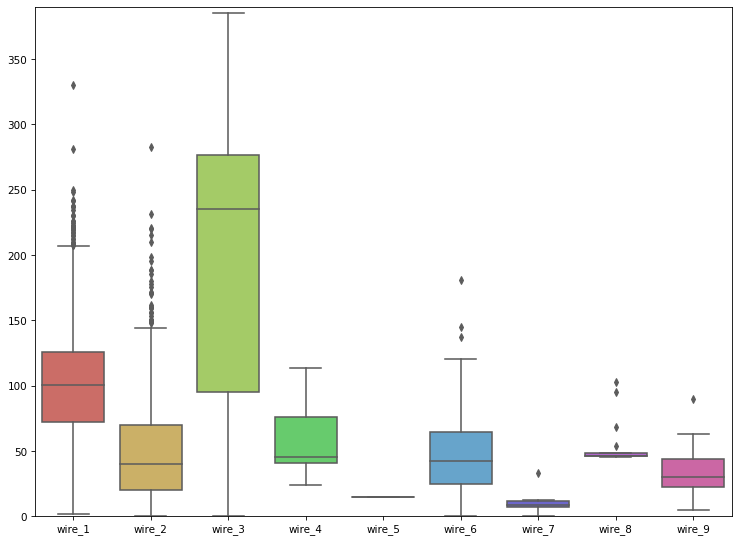

In [54]:
box_plotter(data_wire, data_wire.columns.to_list()[1:], values_range=(0, 390))

У wire_3 самое большое стандартное отклонение, ввиду чего все значения попали в интервал межквартильного размаха. Самые богатые на количество записей столбцы wire_1 и wire_2 содержат 3 сильных выброса. Представляется, что их лучше пометить подозрительными.

In [55]:
data_wire[(data_wire['wire_1'] > 270) | (data_wire['wire_2'] > 270)]

key      wire_1      wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
1201  1269  142.365600  282.780152     NaN     NaN     NaN     NaN     NaN   
1392  1464  280.987214         NaN     NaN     NaN     NaN     NaN     NaN   
1732  1821  330.314424   69.337838     NaN     NaN     NaN     NaN     NaN   

      wire_8  wire_9  
1201     NaN     NaN  
1392     NaN     NaN  
1732     NaN     NaN

In [56]:
for i in data_wire[(data_wire['wire_1'] > 270) | (data_wire['wire_2'] > 270)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808, 1269, 1464, 1821]

In [57]:
data_wire.fillna(0, inplace=True)
data_wire

key      wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      wire_8  wire_9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
3076     0.0     0.0  
3077     0.0     0.0  
3078     0.0     0.0  
3079     0.0     0.0  
3080     0.0     0.0  

[3081 rows x 10 columns]

In [58]:
heatmap_plotter(data_wire.drop(labels='key', axis=1))

Использование любой из наиболее часто употребляемых добавок не влияет на использование другой добавки, корреляция между ними составляет -0.048. Самая высокая корреляция наблюдается между wire_4 и wire_6, wire_6 и wire_7, но частота использования этих добавок очень низкая.

### Данные о продувке сплава газом

In [60]:
data_gas.head(15)

key      Газ 1
0     1  29.749986
1     2  12.555561
2     3  28.554793
3     4  18.841219
4     5   5.413692
5     6  11.273392
6     7   9.836267
7     8  15.171553
8     9   8.216623
9    10   6.529891
10   11   3.639128
11   12  11.026259
12   13  11.443643
13   14   5.098945
14   15  11.085451

Переименуем столбец Газ 1.

In [61]:
data_gas.columns = ['key', 'gas_volume']

In [62]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3239 non-null   int64  
 1   gas_volume  3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [63]:
data_gas.duplicated(keep=False).value_counts()

False    3239
dtype: int64

Дубликатов в наборе данных нет.

In [64]:
data_gas.describe()

key   gas_volume
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

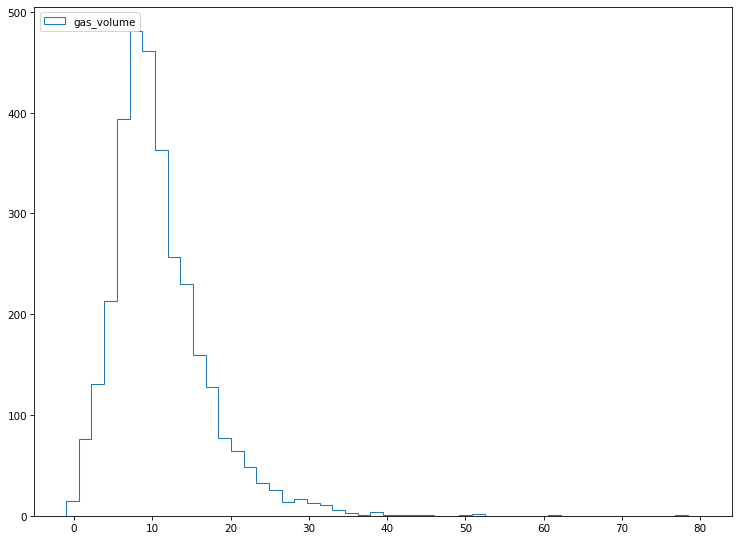

In [65]:
hist_plotter(data_gas, ['gas_volume'], bins=50, values_range=(-1, 80))

На гистограмме виден скос данных вправо с несколькими отдельными выбросами после значения 60.

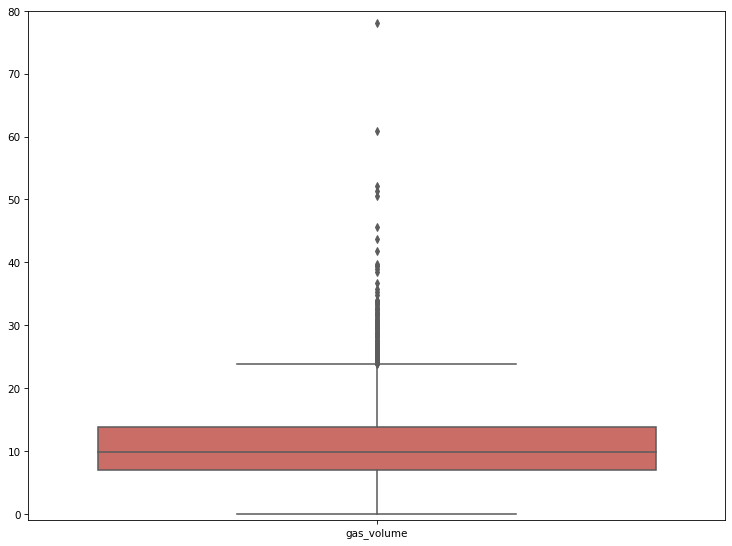

In [66]:
box_plotter(data_gas, ['gas_volume'], values_range=(-1, 80))

Выбросов видно достаточно много, но они в основном сосредоточены в одной большой группе. Представляется правилным пометить подозрительными два ковша, которые сильнее всего выбиваются из общей массы. 

In [67]:
for i in data_gas[(data_gas['gas_volume'] > 57)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808, 1269, 1464, 1821, 280, 322]

### Результаты измерения температуры

Мы подошли к набору данных, содержащему целевой признак.

In [68]:
data_temp.head(15)

key        Время замера  Температура
0     1 2019-05-03 11:16:18       1571.0
1     1 2019-05-03 11:25:53       1604.0
2     1 2019-05-03 11:29:11       1618.0
3     1 2019-05-03 11:30:01       1601.0
4     1 2019-05-03 11:30:39       1613.0
5     2 2019-05-03 11:37:27       1581.0
6     2 2019-05-03 11:38:00       1577.0
7     2 2019-05-03 11:49:38       1589.0
8     2 2019-05-03 11:55:50       1604.0
9     2 2019-05-03 11:58:24       1608.0
10    2 2019-05-03 11:59:12       1602.0
11    3 2019-05-03 12:13:17       1596.0
12    3 2019-05-03 12:18:36       1597.0
13    3 2019-05-03 12:25:06       1598.0
14    3 2019-05-03 12:30:48       1599.0

In [69]:
data_temp.columns = ['key', 'measuring_time', 'temperature']

In [70]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             15907 non-null  int64         
 1   measuring_time  15907 non-null  datetime64[ns]
 2   temperature     13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Видно, что в наборе данных содержится 15907 строк, столбец с датой приведен к корректному типу. В столбце `temperature` мы видим почти 3000 пропусков, которые нужно обработать. 

In [71]:
data_temp.duplicated(keep=False).value_counts()

False    15907
dtype: int64

Записей-дубликатов в наборе данных нет.

In [72]:
data_temp.describe()

key   temperature
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Исходя из вышеуказанной таблицы можно сделать вывод, что в наборе данных присутствуют записи с температурой стали около 1200 градусов цельсия. Так как в задаче речь идет про жидкую сталь, температура плавления которой составляет около 1500 градусов цельсия, значения ниже этого показателя выглядят недостоверными с физической точки зрения.

In [73]:
hist_plotter(data_temp,['temperature'], values_range=(1000, 1750))

In [74]:
box_plotter(data_temp,['temperature'], values_range=(1000, 1750))

Ковшей, температура которых выглядит не до конца достоверно с физической точки зрения, не очень много. Лучше от них избавиться.

In [75]:
for i in data_temp[(data_temp['temperature'] < 1500)]['key'].unique():
    keys_to_delete.append(i)
keys_to_delete

[2116, 867, 1214, 1619, 1818, 2052, 2561]

Целевым признаком для нашей модели будет являться финальная температура ковша, первоначальную температуру ковша будем использовать в качестве признака, ввиду чего нужно обработать данные следующим образом:
- удалить ковши, в которых лишь одна запись измерения температуры;
- удалить ковши, в которых первоначальная и итоговая температуры равны;
- удалить ковши, в которых первоначальная или итоговая температуры пропущены.

Начнем с первого буллита.

In [76]:
data_temp_pivot = data_temp.pivot_table(index=['key'], values=['measuring_time'], aggfunc='count')
data_temp_pivot.sort_values(by='measuring_time')

measuring_time
key                 
279                1
195                1
2497               2
151                2
1415               2
...              ...
2108              15
1214              16
44                16
46                16
1513              16

[3216 rows x 1 columns]

Присутствует лишь два ковша, по которым было зафиксировано одно измерение.

In [77]:
for i in data_temp_pivot.query('measuring_time == 1').index.to_list():
    keys_to_delete.append(i)
keys_to_delete

[2116, 867, 1214, 1619, 1818, 2052, 2561, 195, 279]

Для достижения результата по второму и третьему буллиту нам будет необходимо создать новый набор данных, который будет содержать первоначальную и финальную температуры стали. Для этого избавимся от записей в отношении ковшей, которые ранее были отобраны для этой цели.

In [78]:
indices_to_delete = data_temp.query('key in @keys_to_delete').index.to_list()
data_temp = data_temp.drop(indices_to_delete).reset_index(drop=True)
data_temp.head()

key      measuring_time  temperature
0    1 2019-05-03 11:16:18       1571.0
1    1 2019-05-03 11:25:53       1604.0
2    1 2019-05-03 11:29:11       1618.0
3    1 2019-05-03 11:30:01       1601.0
4    1 2019-05-03 11:30:39       1613.0

In [79]:
indices_to_delete = data_temp.query('key in @keys_to_delete').index.to_list()
indices_to_delete

[]

Порядок наведен, можно делать новый набор данных. Создадим фильтр, в котором отсортируем данные по ковшу и времени замера, чтобы не нарушилась хронология, вызовем метод `duplicated()` с аргуметом `keep='first'` для столбца `key`. Данная часть фильра создаст булев массив, в котором строка с первоначальной температурой по каждому ковшу будет помечена как `False`. Далее инвертируем этот массив, сравнив его с `True` c помощью оператора неравенства. С помощью получившегося булевого массива отберем необходимые значения для нового датафрейма.

In [80]:
start_filter = data_temp.sort_values(by=['key', 'measuring_time'])['key'].duplicated(keep='first') != True
data_temp_start = data_temp[start_filter]
data_temp_start.columns = ['key', 'measuring_time', 'start_temperature']
data_temp_start

key      measuring_time  start_temperature
0         1 2019-05-03 11:16:18             1571.0
5         2 2019-05-03 11:37:27             1581.0
11        3 2019-05-03 12:13:17             1596.0
16        4 2019-05-03 12:52:57             1601.0
19        5 2019-05-03 13:23:19             1576.0
...     ...                 ...                ...
15822  3237 2019-08-31 22:44:04             1569.0
15827  3238 2019-08-31 23:30:31             1584.0
15830  3239 2019-09-01 01:31:47             1598.0
15838  3240 2019-09-01 02:39:01             1617.0
15846  3241 2019-09-01 04:03:30             1586.0

[3207 rows x 3 columns]

Сделаем похожий набор данных для финальной температуры, изменив в фильтре параметр `keep='first'` на `keep='last'` в методе `duplicated()`.

In [81]:
end_filter = data_temp.sort_values(by=['key', 'measuring_time'])['key'].duplicated(keep='last') != True
data_temp_end = data_temp[end_filter]
data_temp_end.columns = ['key', 'measuring_time', 'end_temperature']
data_temp_end

key      measuring_time  end_temperature
4         1 2019-05-03 11:30:39           1613.0
10        2 2019-05-03 11:59:12           1602.0
15        3 2019-05-03 12:34:57           1599.0
18        4 2019-05-03 12:59:25           1625.0
20        5 2019-05-03 13:36:01           1602.0
...     ...                 ...              ...
15826  3237 2019-08-31 23:05:43              NaN
15829  3238 2019-08-31 23:43:00              NaN
15837  3239 2019-09-01 02:24:15              NaN
15845  3240 2019-09-01 03:35:16              NaN
15850  3241 2019-09-01 04:38:08              NaN

[3207 rows x 3 columns]

Создадим таблицу, которая будет содержать номер ковша, начальную и конечную температуру стали. Сделаем объединенную таблицу.

In [82]:
data_temp_merged = data_temp_start.merge(data_temp_end, left_on='key', right_on='key', how='outer')
data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3207 entries, 0 to 3206
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                3207 non-null   int64         
 1   measuring_time_x   3207 non-null   datetime64[ns]
 2   start_temperature  3207 non-null   float64       
 3   measuring_time_y   3207 non-null   datetime64[ns]
 4   end_temperature    2469 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.3 KB


В стобце `end_temperature` у нас много пропусков. Так как это целевой признак, нам придется удалить ковши с пропусками. В `start_temperature` пропусков нет.

In [83]:
data_temp_merged.dropna(inplace=True)
data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2468
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2469 non-null   int64         
 1   measuring_time_x   2469 non-null   datetime64[ns]
 2   start_temperature  2469 non-null   float64       
 3   measuring_time_y   2469 non-null   datetime64[ns]
 4   end_temperature    2469 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 115.7 KB


Далее найдем записи, в которых начальная и конечная температура равны.

In [84]:
data_temp_merged['to_delete'] = data_temp_merged['start_temperature'] == data_temp_merged['end_temperature']
data_temp_merged['to_delete'].value_counts()

False    2427
True       42
Name: to_delete, dtype: int64

Есть несколько записей с одинаковыми начальной и конечной температурами, удалим их.

In [85]:
data_temp_merged = data_temp_merged[data_temp_merged['to_delete'] == False]

Далее целесообразно удалить столбец `to_delete`, а также столбцы с датами и временем измерений. Попробуем извлечь из них какой-нибудь полезный признак перед удалением, например, количество секунд между первым и последним замером температуры.

In [86]:
data_temp_merged['time_diff'] = data_temp_merged['measuring_time_y'] - data_temp_merged['measuring_time_x']
data_temp_merged['time_diff'] = data_temp_merged['time_diff'].astype('timedelta64[s]').astype('int')
data_temp_merged

key    measuring_time_x  start_temperature    measuring_time_y  \
0        1 2019-05-03 11:16:18             1571.0 2019-05-03 11:30:39   
1        2 2019-05-03 11:37:27             1581.0 2019-05-03 11:59:12   
2        3 2019-05-03 12:13:17             1596.0 2019-05-03 12:34:57   
3        4 2019-05-03 12:52:57             1601.0 2019-05-03 12:59:25   
4        5 2019-05-03 13:23:19             1576.0 2019-05-03 13:36:01   
...    ...                 ...                ...                 ...   
2464  2495 2019-08-06 00:35:45             1570.0 2019-08-06 00:54:42   
2465  2496 2019-08-06 01:02:54             1554.0 2019-08-06 01:29:52   
2466  2497 2019-08-06 01:41:53             1571.0 2019-08-06 01:53:50   
2467  2498 2019-08-06 02:03:49             1591.0 2019-08-06 02:25:31   
2468  2499 2019-08-06 02:40:25             1569.0 2019-08-06 03:00:28   

      end_temperature  to_delete  time_diff  
0              1613.0      False        861  
1              1602.0      False       1305  
2              1599.0      False       1300  
3              1625.0      False        388  
4              1602.0      False        762  
...               ...        ...        ...  
2464           1591.0      False       1137  
2465           1591.0      False       1618  
2466           1589.0      False        717  
2467           1594.0      False       1302  
2468           1603.0      False       1203  

[2427 rows x 7 columns]

Теперь удалим лишние столбцы.

In [87]:
data_temp_merged.drop(['to_delete', 'measuring_time_x', 'measuring_time_y'], axis=1, inplace=True)
data_temp_merged

key  start_temperature  end_temperature  time_diff
0        1             1571.0           1613.0        861
1        2             1581.0           1602.0       1305
2        3             1596.0           1599.0       1300
3        4             1601.0           1625.0        388
4        5             1576.0           1602.0        762
...    ...                ...              ...        ...
2464  2495             1570.0           1591.0       1137
2465  2496             1554.0           1591.0       1618
2466  2497             1571.0           1589.0        717
2467  2498             1591.0           1594.0       1302
2468  2499             1569.0           1603.0       1203

[2427 rows x 4 columns]

Набор данных с целевым признаком готов к объединению.

### Объединение датафреймов

Последовательно объединим все наборы данных в один, для объединения будем использовать столбец `key`. Объединять будем по типу `inner`, чтобы в итоговый набор не попали данные по ковшам, которых нет в наборе данных с целевым признаком.

In [88]:
merged_data = data_temp_merged.merge(data_arc_agg, left_on='key', right_on='key', how='inner')

In [89]:
merged_data = merged_data.merge(data_bulk, left_on='key', right_on='key', how='inner')

In [90]:
merged_data = merged_data.merge(data_wire, left_on='key', right_on='key', how='inner')

In [91]:
merged_data = merged_data.merge(data_gas, left_on='key', right_on='key', how='inner')

In [92]:
merged_data.nunique()

key                     2288
start_temperature        133
end_temperature           75
time_diff               1561
active_power_sum        2288
reactive_power_sum      2288
active_power_mean       2288
reactive_power_mean     2288
active_power_count        15
reactive_power_count      15
bulk_1                    38
bulk_2                    13
bulk_3                   264
bulk_4                   199
bulk_5                    43
bulk_6                   187
bulk_7                    14
bulk_8                     2
bulk_9                    10
bulk_10                   70
bulk_11                   82
bulk_12                  301
bulk_13                   11
bulk_14                  254
bulk_15                  143
wire_1                  1786
wire_2                   558
wire_3                    35
wire_4                    13
wire_5                     1
wire_6                    43
wire_7                     5
wire_8                    10
wire_9                    22
gas_volume    

Итого у нас получилось 2293 записи вместо 2433, что связано с отсутствием части ковшей из основного набора данных в оставшихся наборах. Также в итоговом наборе данных у нас есть столбец wire_5 с единственным значением.

In [93]:
merged_data['wire_5'].unique()

array([0.])

По хорошему этот столбце лучше удалить, так как он не поможет в обучении модели.

In [95]:
missing_values_table(merged_data)

Empty DataFrame
Columns: [Отсутствующие значения, % от общего количества значений]
Index: []

Пропусков в наборе данных нет. Посмотрим на корреляции целевого признака с признаками.

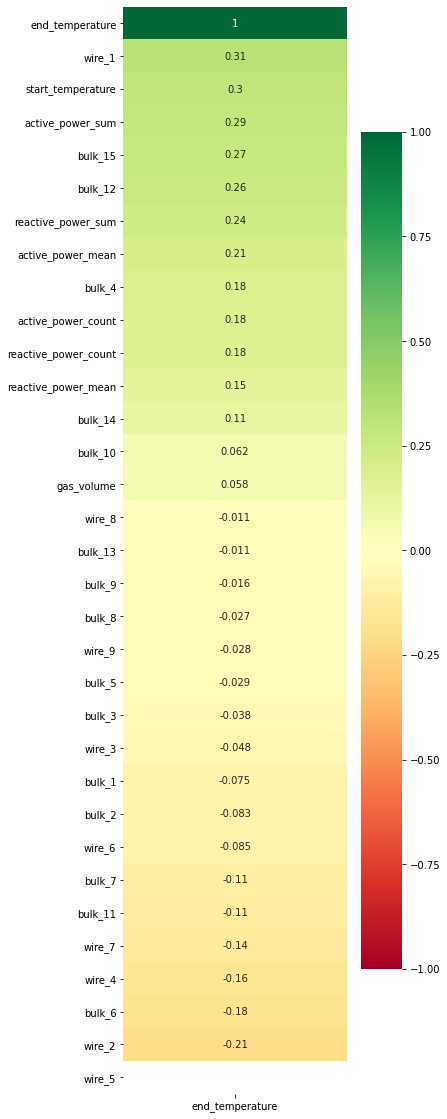

In [96]:
plt.figure(figsize=(5, 20))
sns.heatmap(merged_data.drop(['time_diff', 'key'], axis=1).corr()[['end_temperature']].sort_values(by='end_temperature', 
                  ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
None

Самые сильные положительные корреляции в диапазоне от 0.26 до 0.32 у целевого признака со стартовой температурой и суммарным количеством энергии, а также с использованием добавок wire_1, bulk_12 и bulk_15. Самые сильные отрицательные корреляции выявлены с добавками wire_2, wire_4 и bulk_6, но они находятся в диапазоне от -0.16 до -0.22. Положительные корреляции можно интерпретировть как слабые, отрицательные - как очень слабые. Сильных корреляций не выявлено.

Посмотрим на корреляции признаков между собой

In [97]:
heatmap_plotter(merged_data.drop(['time_diff', 'key'], axis=1), figure_size=(30, 30), dots_per_inch=100)

Поработаем с мультиколлинеарностью. Так как на этапе изучения набора данных `data_arc` мы установили, что между показателями `active_power` и `reactive_power` корреляция около 96%, закономерным является то, что корреляция между агрегированными данными по этому столбцу высокая. Попробуем убрать из набора данных столбцы, касающиеся `reactive_power`, после чего еще раз взглянем на тепловую карту.


In [98]:
heatmap_plotter(merged_data.drop(['time_diff', 'key', 'reactive_power_sum', 
                                  'reactive_power_mean','reactive_power_count', 'wire_5'], 
                                   axis=1), figure_size=(30, 30), dots_per_inch=100)

Заметно, что температура находится в обратной зависимости от затраченной энергии. Это кажется логичным, так как для разогрева до определенной температуры меньше энергии понадобится в том ковше, в котором изначальная температура выше. По некоторым добавкам четко прослеживается тенденция к их совместному употреблению, например wire_8 и bulk_9 почти всегда употребляются вместе, тогда как, например, bulk_3 и bulk_4 наоборот редко используются вместе. Добавление некоторых добавок заметно влияет на рост температуры и затраченной энергии, например, bulk_12 и bulk_15. Некоторые добавки снижают температуру, например wire_3. 

Представляется, что один из столбцов в паре bulk_9 и wire_8 целесообразно удалить ввиду их корреляции в 97%. Удалим wire_8, а также wire_5, по которому вообще нет ни одной записи в итоговом наборе данных. 

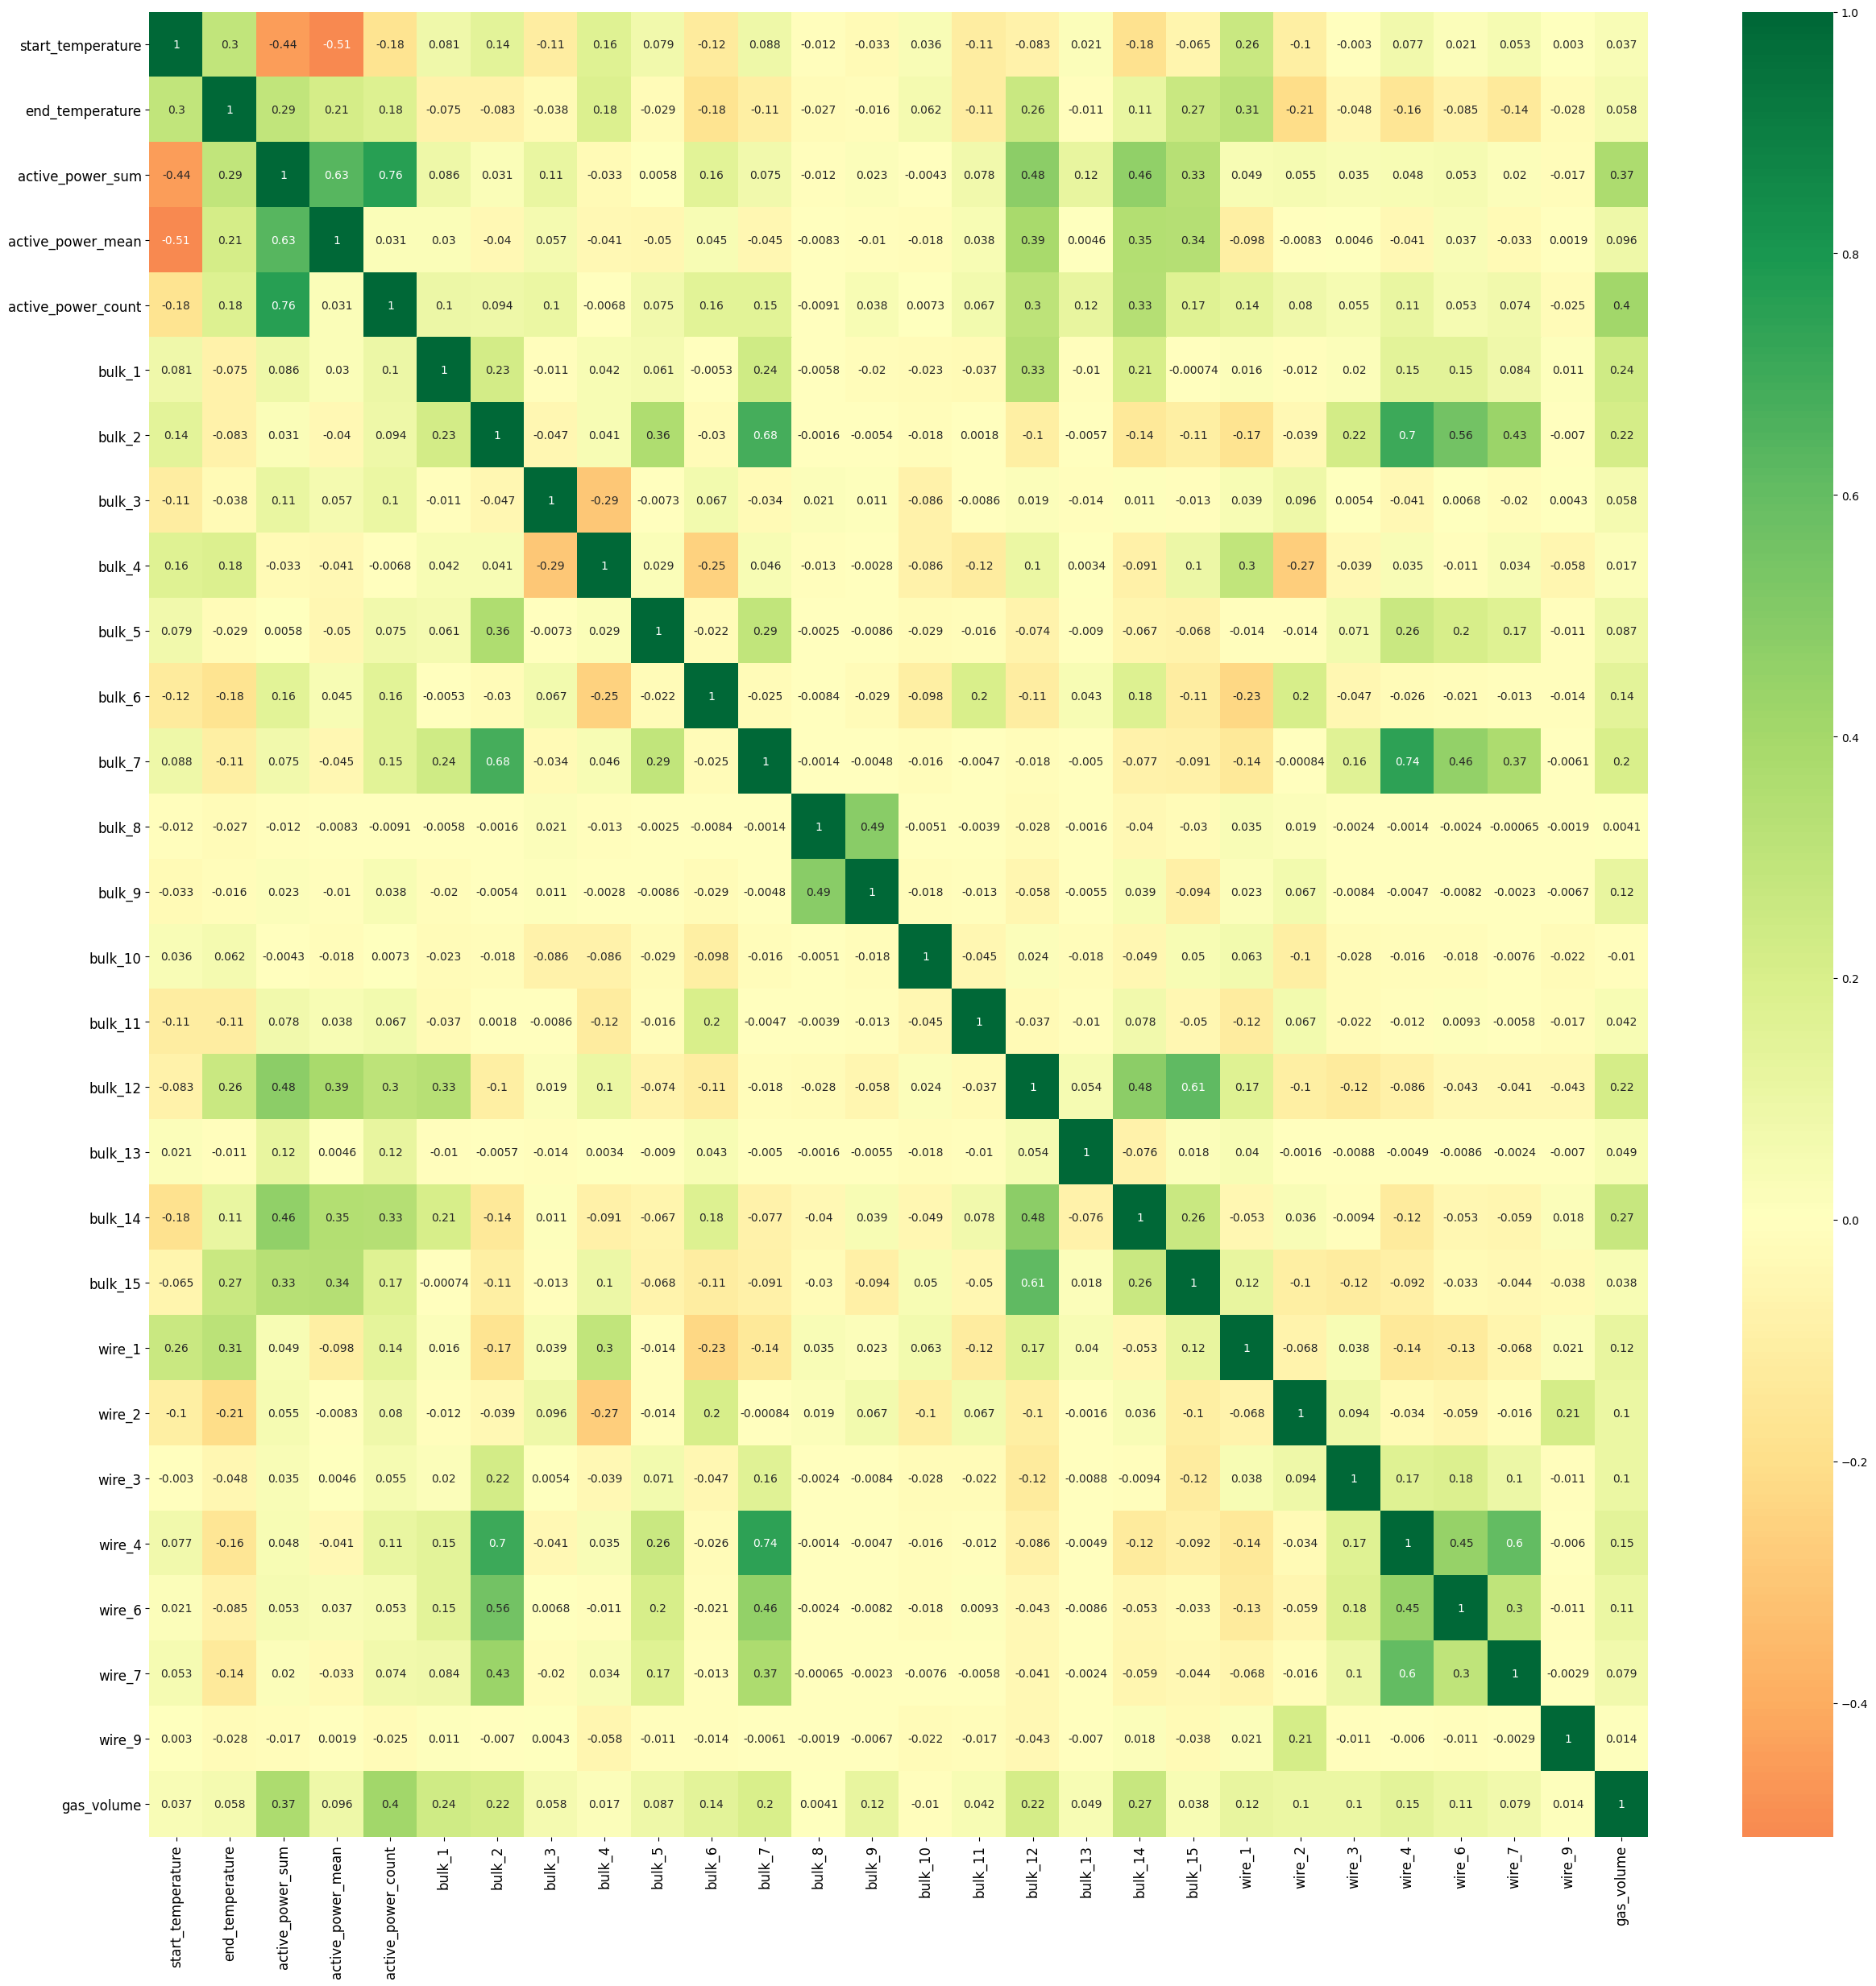

In [99]:
heatmap_plotter(merged_data.drop(['time_diff', 'key', 'reactive_power_sum', 
                                  'reactive_power_mean','reactive_power_count',
                                  'wire_5', 'wire_8'], 
                                   axis=1), figure_size=(30, 30), dots_per_inch=100)

Очень высоких корреляций на тепловой карте не осталось. Попробуем обучить модель на этом наборе данных.

| [Импорт библиотек](#Импорт-библиотек)  |  [Загрузка данных](#Загрузка-данных)  |  [Исследовательский анализ данных](#Исследовательский-анализ-данных)
| [Обучение модели](#Обучение-модели)  |

## Обучение модели

Еще раз посмотрим на итоговый набор данных, удалив из него столбцы с высокой корреляцией, а также "пустой" wire_5.

In [100]:
merged_data = merged_data.drop(labels=['reactive_power_sum', 'reactive_power_mean',
                                       'reactive_power_count', 'wire_5', 'wire_8'], axis=1)

In [101]:
merged_data.head(15)

key  start_temperature  end_temperature  time_diff  active_power_sum  \
0     1             1571.0           1613.0        861          4.878147   
1     2             1581.0           1602.0       1305          3.052598   
2     3             1596.0           1599.0       1300          2.525882   
3     4             1601.0           1625.0        388          3.209250   
4     5             1576.0           1602.0        762          3.347173   
5     6             1543.0           1596.0       1385          3.955108   
6     7             1586.0           1599.0       1374          2.547375   
7     8             1577.0           1598.0        934          3.762755   
8     9             1587.0           1592.0       1453          2.081951   
9    10             1574.0           1593.0       1299          2.923622   
10   11             1616.0           1597.0       1985          2.297512   
11   12             1606.0           1591.0       1929          2.581517   
12   13             1596.0           1619.0       1636          4.051819   
13   14             1583.0           1606.0       2260          4.510224   
14   15             1605.0           1598.0       2061          2.351276   

    active_power_mean  active_power_count  bulk_1  bulk_2  bulk_3  bulk_4  \
0            0.975629                   5     0.0     0.0     0.0    43.0   
1            0.763150                   4     0.0     0.0     0.0    73.0   
2            0.505176                   5     0.0     0.0     0.0    34.0   
3            0.802313                   4     0.0     0.0     0.0    81.0   
4            0.836793                   4     0.0     0.0     0.0    78.0   
5            0.988777                   4     0.0     0.0     0.0   117.0   
6            0.636844                   4     0.0     0.0     0.0   117.0   
7            0.940689                   4     0.0     0.0     0.0    99.0   
8            0.416390                   5     0.0     0.0     0.0   117.0   
9            0.487270                   6     0.0     0.0     0.0     0.0   
10           0.459502                   5     0.0     0.0     0.0    69.0   
11           0.645379                   4    46.0     0.0     0.0    34.0   
12           0.675303                   6     0.0     0.0     0.0     0.0   
13           0.751704                   6     0.0     0.0    71.0     0.0   
14           0.470255                   5     0.0     0.0     0.0     0.0   

    bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  \
0      0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0   
1      0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0   
2      0.0     0.0     0.0     0.0     0.0      0.0      0.0    205.0   
3      0.0     0.0     0.0     0.0     0.0      0.0      0.0    207.0   
4      0.0     0.0     0.0     0.0     0.0      0.0      0.0    203.0   
5      0.0     0.0     0.0     0.0     0.0      0.0      0.0    204.0   
6      0.0     0.0     0.0     0.0     0.0      0.0      0.0    204.0   
7      0.0     0.0     0.0     0.0     0.0      0.0      0.0    410.0   
8      0.0     0.0     0.0     0.0     0.0      0.0      0.0    107.0   
9      0.0     0.0     0.0     0.0     0.0      0.0      0.0    203.0   
10     0.0     0.0     0.0     0.0     0.0      0.0      0.0    207.0   
11     0.0     0.0     0.0     0.0     0.0      0.0      0.0    618.0   
12     0.0    72.0     0.0     0.0     0.0      0.0      0.0    410.0   
13     0.0     0.0     0.0     0.0     0.0      0.0      0.0    204.0   
14     0.0    77.0     0.0     0.0     0.0      0.0      0.0      0.0   

    bulk_13  bulk_14  bulk_15      wire_1     wire_2  wire_3  wire_4  wire_6  \
0       0.0    150.0    154.0   60.059998   0.000000     0.0     0.0     0.0   
1       0.0    149.0    154.0   96.052315   0.000000     0.0     0.0     0.0   
2       0.0    152.0    153.0   91.160157   0.000000     0.0     0.0     0.0   
3       0.0    153.0    154.0   89.063515   0.000000     0.0     

Объявим функцию, которая будет осуществлять разделение данных на обучающую и тестовую выборки. Ранее мы определили, что подозрительные значения будем удалять только из обучающей выборк. После разделения данных на две выборки из тестовой выборки будут удалены те записи, значения столбца `key` которых входит в список `suspicious_keys`. Далее из всех выборок будет удален столбец `key`, так как для обучения он нам не понадобится. Последним этапом работы нашей функции будет масштабирование признаков под обучающую выборку. Возвращать функция будет 4 рабора данных: 2 с признаками, 2 с целевыми признаками.

In [102]:
def data_processer(df):
    target = df.filter(['key','end_temperature'], axis=1)
    features = df.drop(labels=['end_temperature'], axis=1)
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                train_size=0.80, 
                                                                                random_state=12092022)
    print("Размеры Train/Test Sizes: ", features_train.shape, features_test.shape, 
                                        target_train.shape, target_test.shape)
    
    features_train = features_train.query('key not in @suspicious_keys')
    features_train.drop(labels='key', axis=1, inplace=True)
    
    target_train = target_train.query('key not in @suspicious_keys')
    target_train.drop(labels='key', axis=1, inplace=True)
    
    features_test.drop(labels='key', axis=1, inplace=True)
    target_test.drop(labels='key', axis=1, inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train[features_train.columns.to_list()] = scaler.transform(features_train)
    features_test[features_test.columns.to_list()] = scaler.transform(features_test)
    
    return features_train, features_test, target_train, target_test

Перед началом обучения модели определим базовую линию, от которой будем отталкиваться далее при анализе результата работы модели, для чего будем использовать предсказания модели `DummyRegressor`.

In [104]:
dummy = DummyRegressor()
dummy.fit(features_train, target_train)
dummy_prediction = dummy.predict(features_test)
MAE_dummy = mean_absolute_error(target_test, dummy_prediction)
MAE_dummy

8.119339594424835

Dummy-модель показала значение метрики МАЕ около 8.12. Будем использовать это значение в дальнейшем.

Объявим функцию, которая будет осуществлять перебор нескольких моделей в цикле, и, в зависимости от вида модели, будет осуществлять GridSearch в соответствии с переданной в качестве аргумента сетки параметров для каждой из моделей (предусмотрены параметры по умолчанию). Оценка моделей будет производиться по метрике МАЕ, которую также можно изменить при вызове функции. Название лучшей модели, её оценка и гиперпараметры будут возвращаться при условии, что показатель метрики лучше, чем наша базовая линия. 

In [105]:
def modeller(model, features, target, baseline, 
             lr_param=[{'normalize' : [True, False]}],
             rfr_param=[{'n_estimators': range(1, 100, 10), 
                         'max_depth': range(1, 9, 1), 
                         'min_samples_leaf': range(1, 4), 
                         'min_samples_split': range(2, 4, 2)}],
             knn_param=[{'n_neighbors' : range(3, 100, 2),
                         'weights' : ['distance', 'uniform']}],
             metrics='neg_mean_absolute_error'):
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    for i in model:
        if type(i) == LinearRegression:
            param_grid_lr=lr_param
            grid = GridSearchCV(i, param_grid=param_grid_lr, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
        
        elif type(i) == RandomForestRegressor:
            param_grid_rfr=rfr_param
            grid = GridSearchCV(i, param_grid=param_grid_rfr, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
        
        elif type(i) == KNeighborsRegressor:
            param_grid_knn=knn_param
            grid = GridSearchCV(i, param_grid=param_grid_knn, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
    
    if best_score > baseline:
        print('Ни одна из моделей не показала лучший результат, чем DummyRegressor')
    
    else:
        return best_score, best_model, best_params

Создадим две модели, после чего добавим их в список `models`.

In [106]:
rfr = RandomForestRegressor(random_state=12092022)
lr = LinearRegression()
models = [lr, rfr]

Вызовем функцию `modeller`, передав в нее список моделей, признаки и целевой признак, а также метрику нашего "Dummy" для проверки модели на адекватность. Сетку параметров и метрику трогать пока не будем.

In [107]:
%%time
#test = modeller(models, features_train, target_train, MAE_dummy)
#test

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [108]:
(4.210199261718854,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

(4.210199261718854,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

In [109]:
top_model = RandomForestRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=2, 
                                  n_estimators=91, random_state=12092022)

In [110]:
top_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=3, n_estimators=91,
                      random_state=12092022)

In [111]:
top_model_prediction = top_model.predict(features_test)

In [112]:
MAE_top_model =  mean_absolute_error(target_test, top_model_prediction)
MAE_top_model

5.686707238990162

Мы получили метрику MAE около 5.69, что отвечает требованиям заказчика (модель должна показать значение метрики не более, чем 8.7, а в идеале - не более, чем 6), а также превышает значение модели, которую мы использовали в качестве базовой линии 

С помощью атрибута `feature_importances_` экземпляра класса `RandomForestRegressor` получим массив, содержащий нормализованные веса каждого из признаков. Создадим на основании этого массива датафрейм, который отсортируем по убыванию весов, выведем датафрейм на экран.

In [127]:
importances = top_model.feature_importances_
features = features_test.columns.to_list()
importance_df = pd.DataFrame(zip(features, importances), columns=['feature', 'weight'])
importance_df = importance_df.sort_values(by='weight', ascending=False).reset_index(drop=True)
importance_df

feature    weight
0    start_temperature  0.264695
1     active_power_sum  0.220387
2            time_diff  0.081696
3               bulk_6  0.078480
4               wire_1  0.070520
5    active_power_mean  0.060584
6              bulk_15  0.042365
7               wire_2  0.034534
8               bulk_7  0.029591
9              bulk_12  0.028915
10          gas_volume  0.025498
11             bulk_14  0.022824
12              bulk_3  0.009847
13              bulk_4  0.008859
14  active_power_count  0.004365
15              bulk_1  0.004309
16             bulk_11  0.003071
17              wire_4  0.002761
18              wire_3  0.002539
19             bulk_10  0.001576
20              bulk_5  0.001096
21              bulk_2  0.000760
22              wire_6  0.000696
23              wire_9  0.000032
24              bulk_8  0.000000
25             bulk_13  0.000000
26              bulk_9  0.000000
27              wire_7  0.000000

Построим столбчатую диаграмму на основании полученного датафрейма, чтобы визуализировать данные. 

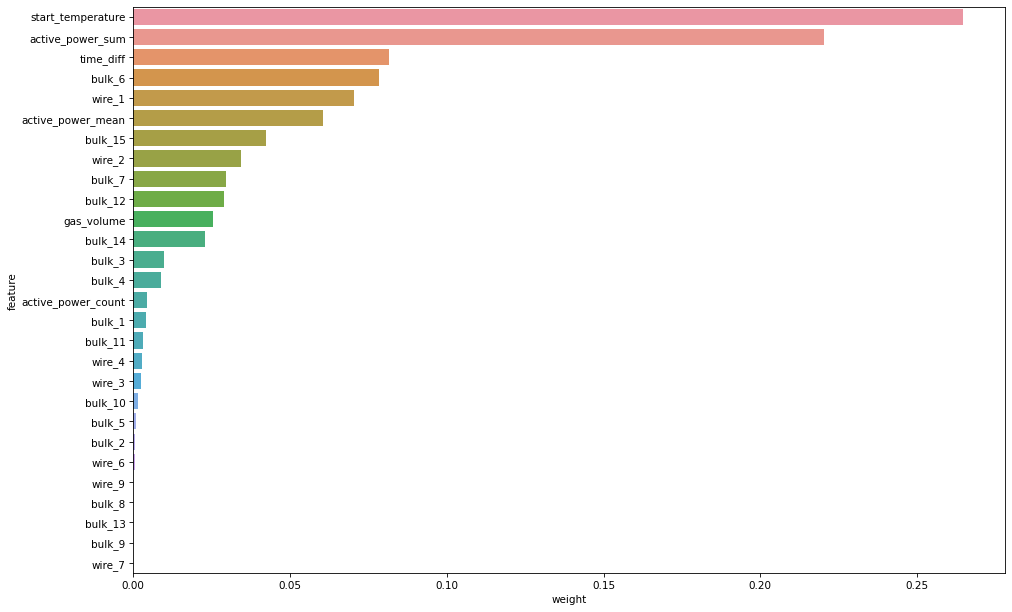

In [114]:
plt.figure(figsize=(15, 10), dpi=75)
sns.barplot(data=importance_df, x='weight', y='feature', orient='h')
None

Максимальное влияние на итоговую температуру оказывает начальная температура в ковше, вес этого признака около 26.4%. Следующий признак - суммарная активная энергия, его вес составил 22%. Примечательно, что третьим по важности идет признак, созданный нашими руками - разница между первым и последним замером в секундах, его вес составляет 8.16%, что примерно равно признаку bulk_6, после которого идет плавнное снижение до признака bulk_14, вес которого составляет 2.28%. bulk_3 и bulk_4 - это последние признаки, которые оказали сколько-нибудь значимое влияение на модель (около 1%). Оставшиеся признаки в модели кажутся избыточными, ввиду чего попробуем оптимизировать её, удалив из выборки соответствующие столбцы, для чего создадим соответствующий фильтр.

In [115]:
features_filter = importance_df[importance_df['weight'] < 0.008859]['feature'].to_list()  # вес bulk_4
features_filter

['active_power_count',
 'bulk_1',
 'bulk_11',
 'wire_4',
 'wire_3',
 'bulk_10',
 'bulk_5',
 'bulk_2',
 'wire_6',
 'wire_9',
 'bulk_8',
 'bulk_13',
 'bulk_9',
 'wire_7']

Заново обучим модель на данных, из которых будут удалены малозначительные признаки, чтобы улушчить интерпретируемость модели.

In [128]:
merged_data_reduced = merged_data.drop(labels=features_filter, axis=1)
merged_data_reduced

key  start_temperature  end_temperature  time_diff  active_power_sum  \
0        1             1571.0           1613.0        861          4.878147   
1        2             1581.0           1602.0       1305          3.052598   
2        3             1596.0           1599.0       1300          2.525882   
3        4             1601.0           1625.0        388          3.209250   
4        5             1576.0           1602.0        762          3.347173   
...    ...                ...              ...        ...               ...   
2283  2495             1570.0           1591.0       1137          3.210690   
2284  2496             1554.0           1591.0       1618          4.203064   
2285  2497             1571.0           1589.0        717          2.212379   
2286  2498             1591.0           1594.0       1302          3.408725   
2287  2499             1569.0           1603.0       1203          4.098431   

      active_power_mean  bulk_3  bulk_4  bulk_6  bulk_7  bulk_12  bulk_14  \
0              0.975629     0.0    43.0     0.0     0.0    206.0    150.0   
1              0.763150     0.0    73.0     0.0     0.0    206.0    149.0   
2              0.505176     0.0    34.0     0.0     0.0    205.0    152.0   
3              0.802313     0.0    81.0     0.0     0.0    207.0    153.0   
4              0.836793     0.0    78.0     0.0     0.0    203.0    151.0   
...                 ...     ...     ...     ...     ...      ...      ...   
2283           0.802673    21.0     0.0     0.0     0.0    256.0    129.0   
2284           0.700511     0.0    63.0     0.0     0.0    256.0    129.0   
2285           0.737460     0.0    85.0     0.0     0.0    230.0    124.0   
2286           0.681745    90.0     0.0     0.0     0.0    206.0    129.0   
2287           1.024608    47.0     0.0     0.0     0.0    233.0    126.0   

      bulk_15      wire_1    wire_2  gas_volume  
0       154.0   60.059998   0.00000   29.749986  
1       154.0   96.052315   0.00000   12.555561  
2       153.0   91.160157   0.00000   28.554793  
3       154.0   89.063515   0.00000   18.841219  
4       152.0   89.238236   9.11456    5.413692  
...       ...         ...       ...         ...  
2283    223.0   89.150879   0.00000    7.125735  
2284    226.0  114.179527   0.00000    9.412616  
2285    226.0   94.086723   9.04800    6.271699  
2286    207.0  118.110717   0.00000   14.953657  
2287    227.0  110.160958  50.00528   11.336151  

[2288 rows x 16 columns]

In [129]:
features_train_reduced, features_test_reduced, target_train_reduced, target_test_reduced = data_processer(merged_data_reduced)
features_train_reduced

Размеры Train/Test Sizes:  (1830, 15) (458, 15) (1830, 2) (458, 2)


start_temperature  time_diff  active_power_sum  active_power_mean  \
2094          -0.420753   0.688255          2.009148           1.588891   
921            0.376058  -0.666322         -1.076323          -0.574039   
50             0.082496   0.318368          1.077529           0.507498   
1054           0.292183  -0.557284         -1.363936          -2.109529   
1979          -0.588502   3.144947          2.385304           0.666338   
...                 ...        ...               ...                ...   
635            0.250246   0.450051          0.364448           0.297973   
478           -1.301438  -0.361856          0.053961          -0.680626   
1850           0.459933   0.354434         -0.167154           0.299670   
1680           1.256743   1.114339          0.117297          -0.046288   
513            0.334120   0.451729         -0.037984          -0.262582   

        bulk_3    bulk_4    bulk_6    bulk_7   bulk_12   bulk_14   bulk_15  \
2094  1.362699 -0.636551 -0.410655 -0.065449  1.354160  0.608247  1.022443   
921  -0.632486 -0.636551  0.788373 -0.065449 -0.274676 -0.141610 -0.224069   
50   -0.632486 -0.636551  1.123395 -0.065449  1.445375  1.033166  0.987165   
1054  2.736866 -0.636551 -0.410655 -0.065449 -1.356224 -1.903774 -1.423544   
1979 -0.302158 -0.636551  0.488616 -0.065449  0.793841  0.595749  0.575580   
...        ...       ...       ...       ...       ...       ...       ...   
635   3.793918 -0.636551 -0.410655 -0.065449 -0.007547  0.020859  0.410947   
478  -0.632486 -0.636551 -0.410655 -0.065449 -0.014062  0.645740  0.387427   
1850 -0.632486  1.151841 -0.410655 -0.065449  0.116244 -0.479046  1.222356   
1680 -0.632486 -0.636551  2.251892 -0.065449 -0.007547  1.195635  0.987165   
513  -0.632486  3.246813 -0.410655 -0.065449  0.311705 -0.604022  0.963646   

        wire_1    wire_2  gas_volume  
2094 -0.060075  0.637016    0.666331  
921  -0.227485 -0.519430   -0.972633  
50   -1.437011 -0.519430   -1.630995  
1054  0.890158 -0.519430   -1.082432  
1979 -0.033615 -0.519430    0.865937  
...        ...       ...         ...  
635  -0.155520 -0.519430    3.476232  
478  -0.271100  0.754621    0.209986  
1850  0.894520 -0.519430   -0.457918  
1680 -0.784671 -0.519430    2.072742  
513   0.893429 -0.519430    1.430153  

[1825 rows x 14 columns]

In [118]:
%%time
#test = modeller(models, features_train, target_train, MAE_dummy)
#test

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [119]:
(4.2265748190835,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

(4.2265748190835,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

In [130]:
top_model_reduced = RandomForestRegressor(random_state=12092022, max_depth=8, 
                                  min_samples_leaf=3, min_samples_split=2,
                                  n_estimators=91)

In [131]:
top_model_reduced.fit(features_train_reduced, target_train_reduced)

RandomForestRegressor(max_depth=8, min_samples_leaf=3, n_estimators=91,
                      random_state=12092022)

In [132]:
top_model_reduced_prediction = top_model_reduced.predict(features_test_reduced)

In [133]:
MAE_top_model_reduced =  mean_absolute_error(target_test_reduced, top_model_reduced_prediction)
MAE_top_model_reduced

5.693224963683407

Улучшения метрики добиться не удалось, она осталась примерно на том же уровне, однако, в модели стало меньше признаков, что сделало её более интерпретируемой и понятной для бизнеса. Выделим топ фич, которые больше всего влияют на модель.

In [124]:
importances_reduced = top_model_reduced.feature_importances_
features = features_test_reduced.columns.to_list()
importances_reduced_df = pd.DataFrame(zip(features, importances), columns=['feature', 'weight'])
importances_reduced_df = importances_reduced_df.sort_values(by='weight', 
                                                            ascending=False).reset_index(drop=True)
importances_reduced_df

feature    weight
0   start_temperature  0.264695
1    active_power_sum  0.220387
2           time_diff  0.081696
3             bulk_15  0.078480
4   active_power_mean  0.060584
5              wire_1  0.029591
6              bulk_7  0.009847
7             bulk_12  0.008859
8              bulk_3  0.004365
9              bulk_4  0.004309
10            bulk_14  0.001096
11             bulk_6  0.000760
12             wire_2  0.000000
13         gas_volume  0.000000

In [125]:
importances_reduced_top5 = importances_reduced_df.head()
importances_reduced_top5

feature    weight
0  start_temperature  0.264695
1   active_power_sum  0.220387
2          time_diff  0.081696
3            bulk_15  0.078480
4  active_power_mean  0.060584

In [126]:
importances_reduced_top5['weight'].sum()

0.7058431854693723

## Вывод по результатам работы

В данной работе мы произвели обширную обработку данных, включающую изучение основных статистик по каждому набору данных, визуализацию данных, работу с дубликатами и пропусками, выявление выбросов и подозрительных значений, изучение коррецяций. 

По двум наборам данных мы также произвели работу по созданию новых наборов данных на основе исходных: мы агрегировали данные по датафрейму data_arc по принципу одна строка - один ковш с использованием нескольких агрегирующих функций, на основе датафрейма data_temp мы сформировали набор данных, содержащий номер ковша, начальную и конечные температуры, а также количество секунд между первым и последним замерами температуры. 

После этого мы объединили все наборы данных. Итоговый набор данных мы проверили на наличие пропусков, а также посмотрели коррелиции. Часть признаков была удалена после анализа на мультиколлинеарность, а также в связи с низким количеством записей. 

После этого мы приступили к созданию обучающей и тестовой выборок, удалив из обучающей выборки подозрительные записи. Последним подготовительным этапом было масштабирование данных.

Для определения лучшей модели мы использовали GridSearchCV и две модели - линейную регрессию и случайный лес. При подборе модели и гиперпараметров мы сразу же производили тест на адекватности модели по целевой метрике.

Лучшей моделью оказался случайный лес, который показал значение метрики МАЕ на тестовой выборке около 5.69. Проанализировав веса признаков в модели мы установили ряд признаков, которые не оказывали существенного влияния на работу модели. Данные признаки были удалены из выборок, после чего была вновь подобрана и обучена модель. 

Показатель метрики МАЕ итоговой модели на тестовых данных оказался незначительно хуже, чем у предыдущей, однако, из-за меньшего количества признаков модель является более интерпретируемой. 

Признаками, оказывающими наибольшее влияние на итоговую модель, являются:
- start_temperature,
- active_power_sum,
- time_diff,
- bulk_15,
- active_power_mean.

Вклад данных признаков составяет 70.5%. 

Признаки, работой над которыми можно уделать меньшее значение, включают в себя: 
- active_power_count, 
- bulk_1,
- bulk_2,
- bulk_5, 
- bulk_11,
- bulk_8,
- bulk_9,
- bulk_10,
- bulk_13,
- wire_3, 
- wire_4, 
- wire_5, 
- wire_6, 
- wire_7, 
- wire_8 
- wire_9.

## Отчёт

# Регрессионная модель по предсказанию температуры стали
<p class="lead">В настоящем разделе предоставлен подробный отчёт, подготовленный по результатам работы с данными, полученными от заказчика - металлургического предприятия. Основная цель работы - <b>построить модель для предсказания температуры стали.</b></p> 

<p class="lead">Для работы нам были предоставлены пять наборов данных, содержащих информацию о нагревах электрической дугой, о добавках (в разрезе количества добавок), о продувке металла газом, а также о замерах температуры расплавленного металла в ковшах.

<p class="lead"><b>Первый этап: подготовка данных</b>
<p class="lead">Для достижения поставленной цели в первую очередь необходимо было решить задачи по первичной обработке и исследованию данных, по работе с пропусками и подозрительными значениями, в том числе, явными выбросами.</p>

<p class="lead">На этапе подготовки данных нами было установлено, что в данных имеются некоторые значения, которые статистически значительно отличаются от основной массы. Такие значения чаще всего встречались в наборах данных, касающихся добавок. Для того, чтобы удостовериться в возможности модели корректно работать с такими значениями, мы осуществили разметку данных, обозначив самые ярки статистические выбросы, как подозрительные значения. Примеры таких значений можно увидеть на нижеприведенном графике, касающемся проволочных добавок (такие значения выглядят как отдельные точки).</p>

| Примеры подозрительных значений по набору данных data_wire |
|-|
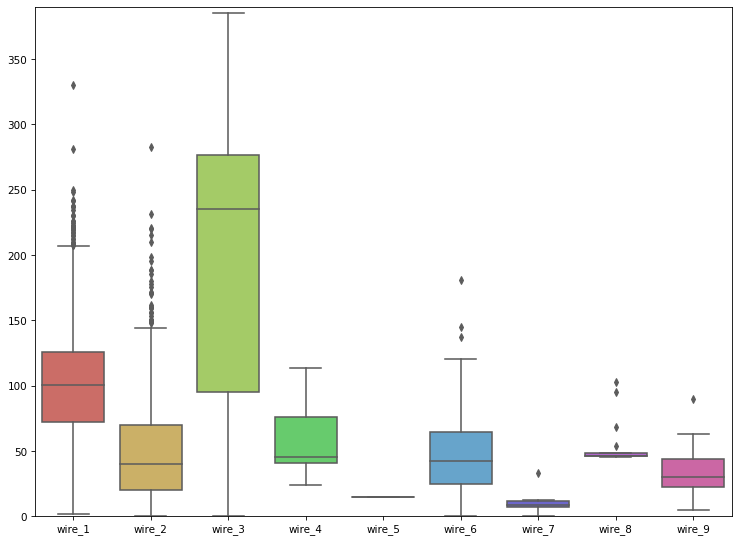

<p class="lead">Информация о ковшах, которые содержат такие подозрительные значения, впоследствии не использовалась для обучения модели, однако, применялась при её тестировании. При наличии подтверждений того, что указанные значения являются корректными и обусловленными особенностями технического процесса, данные значения можно вернуть в набор данных, на котором обучается модель.</p>
<p class="lead">По некоторым данным присутствовали значения, которые не поддавались объяснению с физической точки зрения, например, отрицательная величина реактивной энергии, либо фиксация температуры стали в ковше, значительно меньшей, чем температура её плавления. Такие значения были обозначены как выбросы и были удалены как из набора данных, на которых обучалась модель, так и из набора данных для её тестирования. Примеры таких значений приводятся ниже.</p>

| Примеры выбросов по набору данных data_temp |
|-|
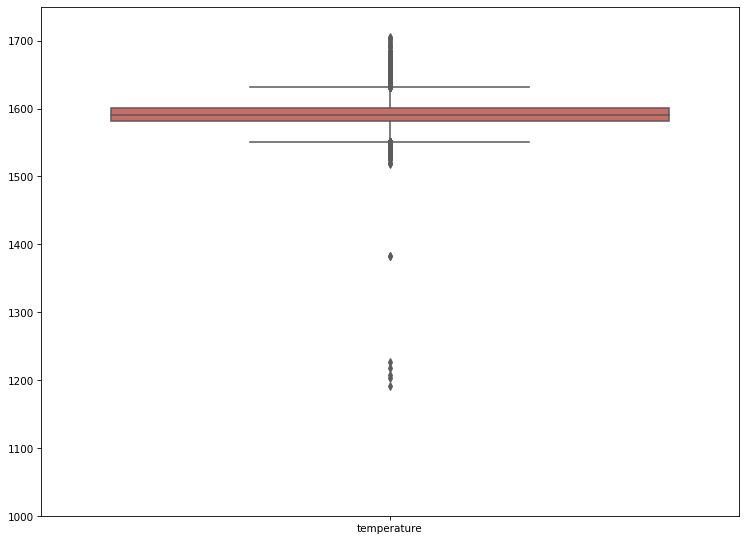

<p class="lead">В рамках подготовительного этапа также были созданы дополнительные признаки, часть из которых сыграла важную роль при построении модели. Например, мы добавили в набор данных информацию об активной и реактивной энергии в агрегированном виде по каждому из ковшей, в частности, их суммарное количество, среднее значение, а также количество итераций нагрева.</p>
<p class="lead">При работе с пропусками мы не использовали никаких специализированных алгоритмов по их заполнению. В наборах данных, которые касались добавок, пропуски были заполнены нулями, так как пропуски, очевидно, свидетельствовали о неиспользовании соответствующей добавки в рамках ковша. Так как поставленная перед нами задача касается предсказания итоговой температуры ковша, нам было важно отсеять все те ковши, которые содержали пропуски в столбце с температурой в хронологически последней итерации. Учитывая тот факт, что начальная температура также является важным признаком, мы отсеяли и те ковши, которые содержали пропуски в хронологически первой итерации. Если итераций нагрева было меньше двух, либо если начальная и конечная температура были равны, мы удаляли такие записи из набора данных, так как в таком случае модель получила бы информацию о целевом значении, которое ей необходимо предсказать (так называемая "утечка целевого признака"). Одним из последних шагов на этом этапе стало объединение всех данных в один набор. Основой для объединения мы выбрали набор данных, который содержал в себе номер ковша, начальную и конечную температуры, а также разницу в секундах между первым и последним замерами.
<p class="lead">В итоге мы получили таблицу, содержащую в себе 2288 записей. В отношении данной таблицы провели работу по поиску корреляций между значениями, в ходе которой часть столбцов была удалена из-за очень высокой корреляции их значений с другими столбцами (так называемая "мультиколлинеарность"). Часть столбцов была также удалена из-за очень низкого количества записей.</p>
<p class="lead">Ниже приводится итоговая тепловая карта корреляций, в которой видны столбцы, рост значений по которым сопровождается ростом значений в другом столбце (зеленый цвет на карте), либо уменьшением значений в другом столбце (красный цвет на карте). Об отсутствии корреляции между двумя признаками говорит желтый цвет на карте. В качестве примера высокой положительной корреляции можно привести добавки bulk_7 и wire_4 - их корреляция составляет 0.74. Пример отрицательной корреляции - начальная температура и среднее количество активной энергии - их корреляция составляет -0.51, что говорит о бОльших затратах электроэнергии в среднем в случаях, когда начальная температура была низкой.</p>

| Итоговая тепловая карта корреляций |
|-|
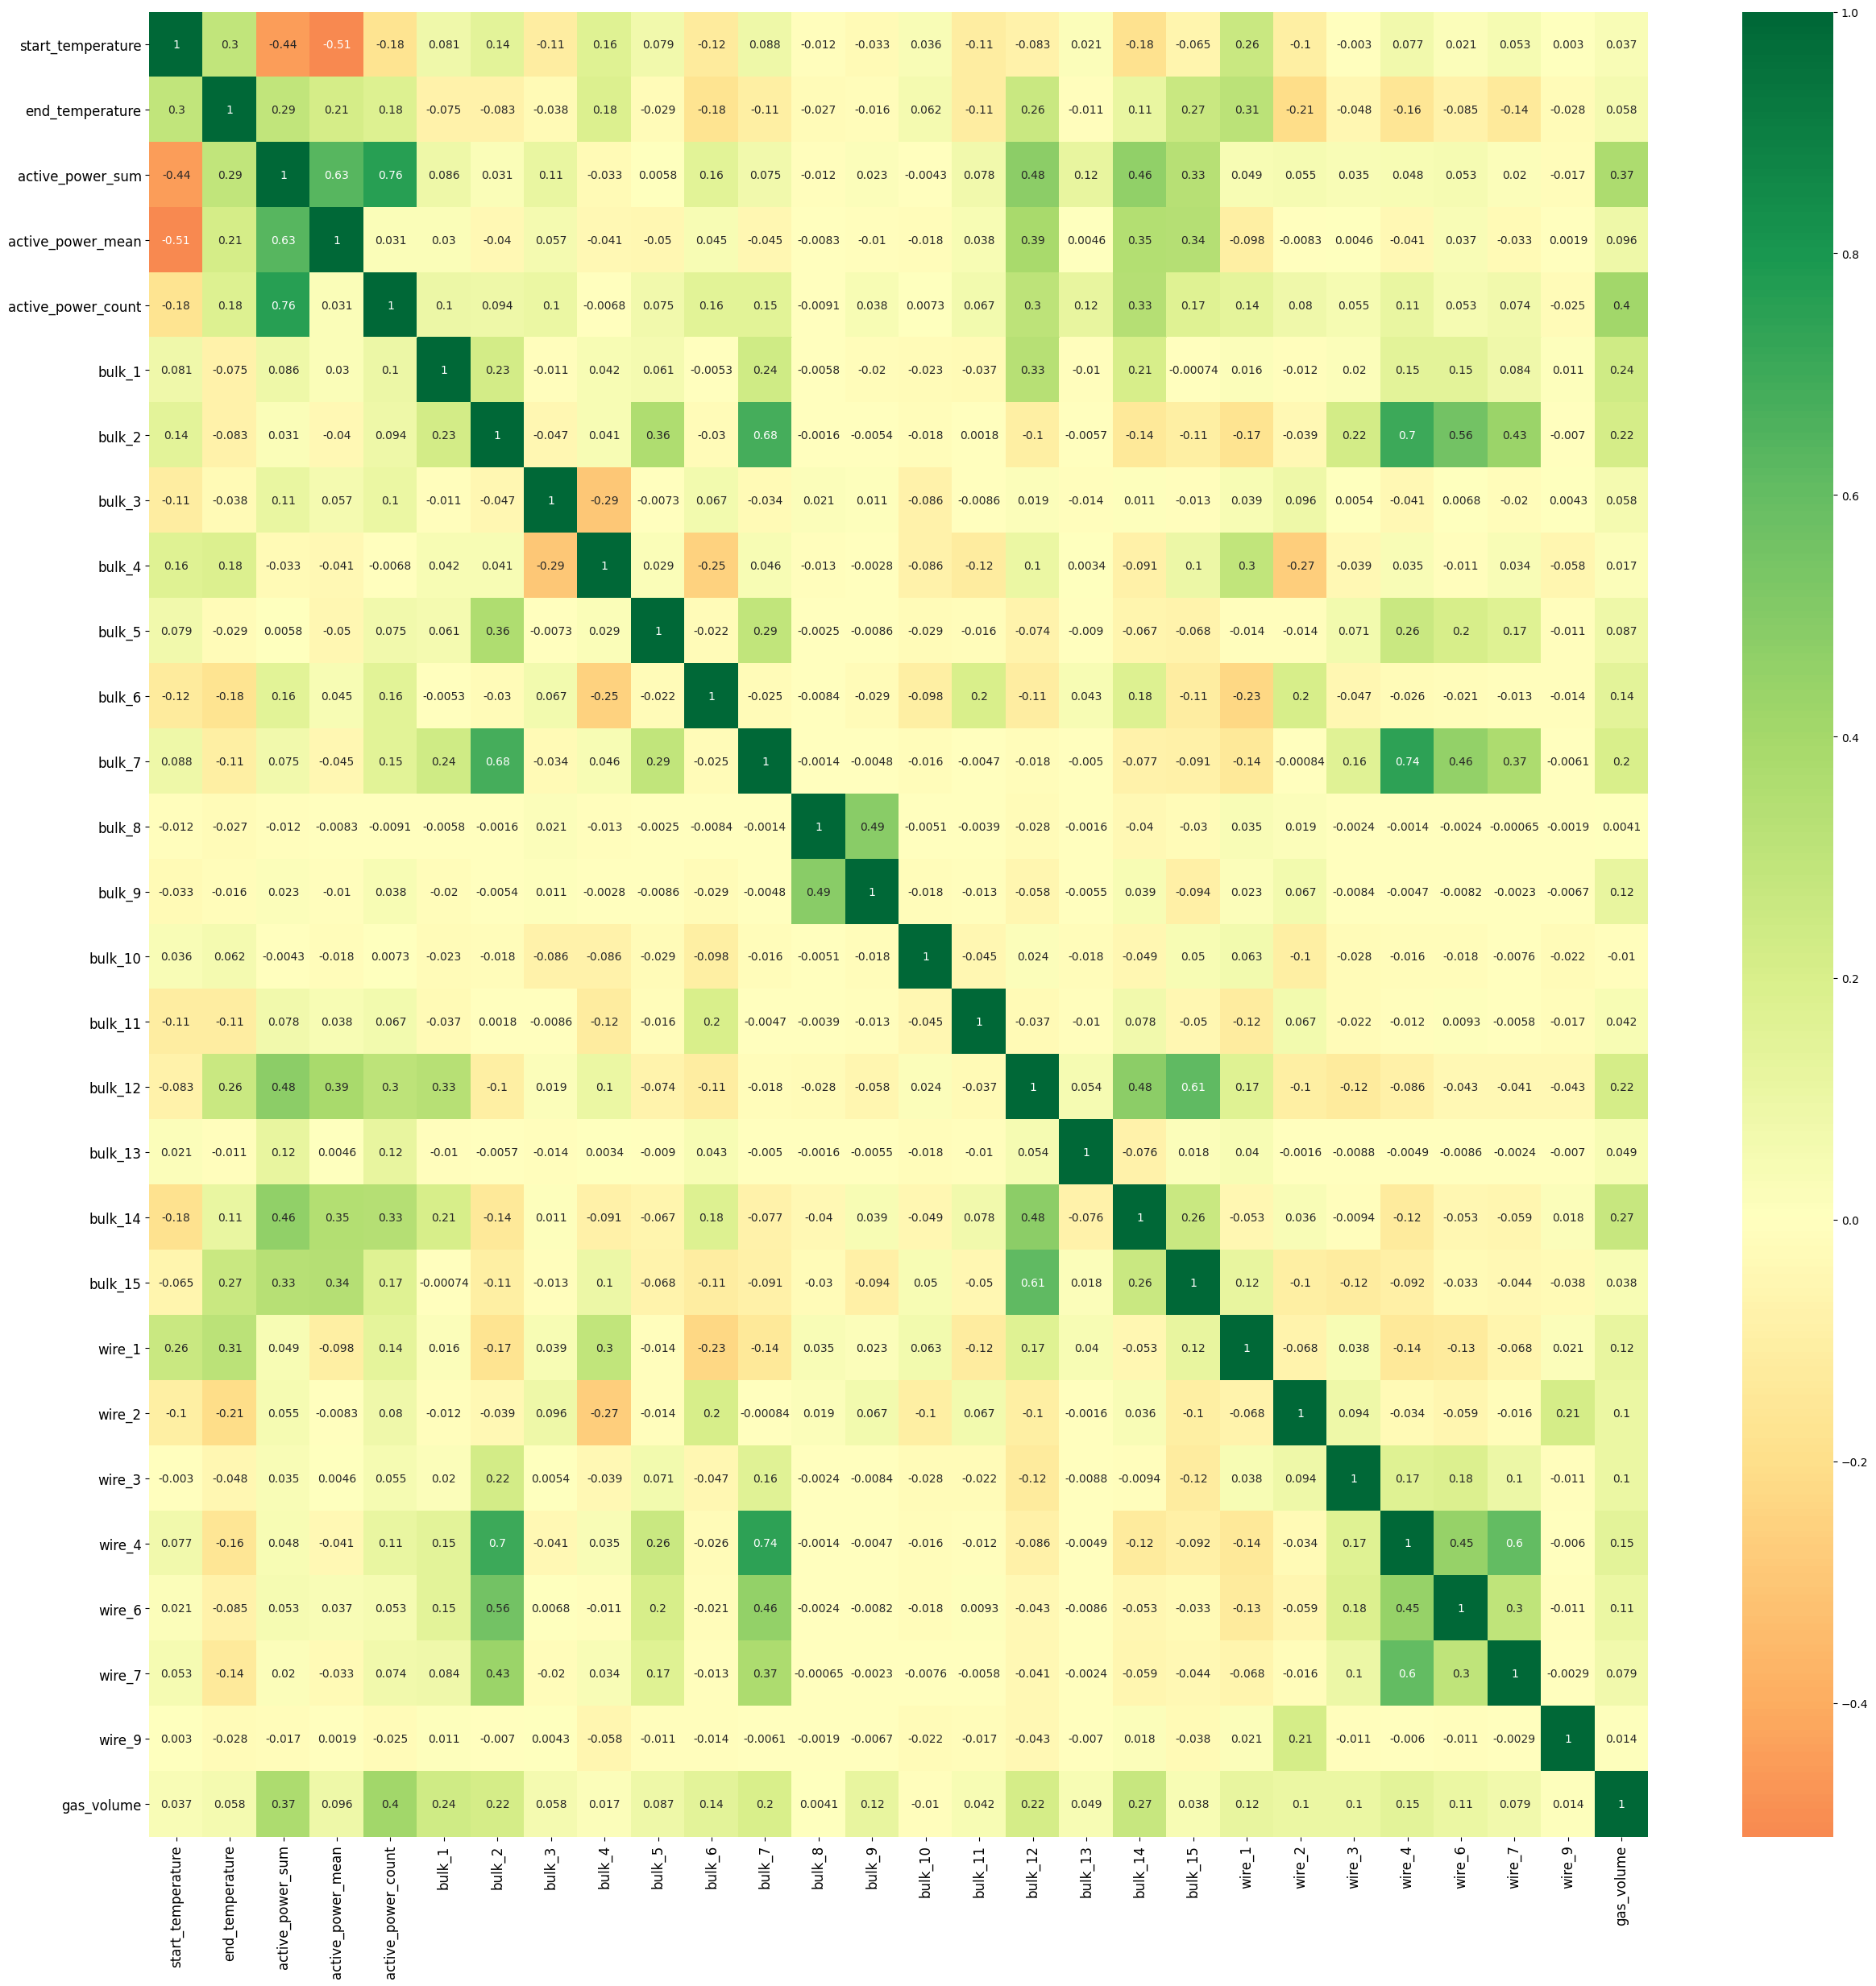

<p class="lead"><b>Второй этап: выбор модели</b>
<p class="lead">Перед выбором модели мы осуществили разделение набора данных на две части: обучающую и тестовую выборки. В обучающей выборке были удалены ковши, содержащие подозрительные значения. Также была произведена работа по приведению данных к одному масштабу: чтобы среднее значение наблюдаемых значений было равно 0, а стандартное отклонение – 1.</p>
<p class="lead">В качестве метрики при работе использовалась "средняя абсолютная ошибка" - среднее абсолютных разностей между целевыми значением и значением, предсказанным моделью на данном обучающем примере (англ. - "mean absolute error"). Перед подбором модели мы определили "базовую линию" - порог мертики, ниже которой модель можно признать более полезной, чем предсказание для любых входных данных среднего значения по обучающему набору данных. Указанная метрика на модели, всегда предсказывающей среднее значение по обучающему набору данных, составила 8.12.
<p class="lead">Подбор моделей и их настроек (так называемых "гиперпараметров") осуществлялся с применением метода "GreedSearchCV", который перебирает все возможные варианты гиперпараметров модели из тех, что были переданы алгоритму для обработки. На каждом наборе гиперпараметров осуществлялся расчет метрики, а гиперпараметры модели с лучшей метрикой сохранялись для дальнейшего использования.</p>
<p class="lead">Для поиска лучшей модели мы использовали два вида моделей - Логистическую регрессию, а также алгоритм Случайного леса. Лучшую метрику продемонстрировал алгоритм Случайного леса - так называемой ансамблевой модели, состоящей из нескольких более простых моделей - Деревьев решений (в нашем случае было использовано 91 Дерево решений), предсказания которых усредняются, что делает данный вид моделей малочувствительным к выбросам. В целом, алгоритм Случайного леса имеет достаточно высокую точность предсказания по сравнению с многими другими моделями.</p>
<p class="lead">Метрика лучшей модели на тестовых данных составила 5.69, что значительно меньше базовой линии. Проанализировав модель, мы выявили те признаки, которые оказали наибольшее влияние на предсказания модели.

| Диаграмма важности признаков |
|-|
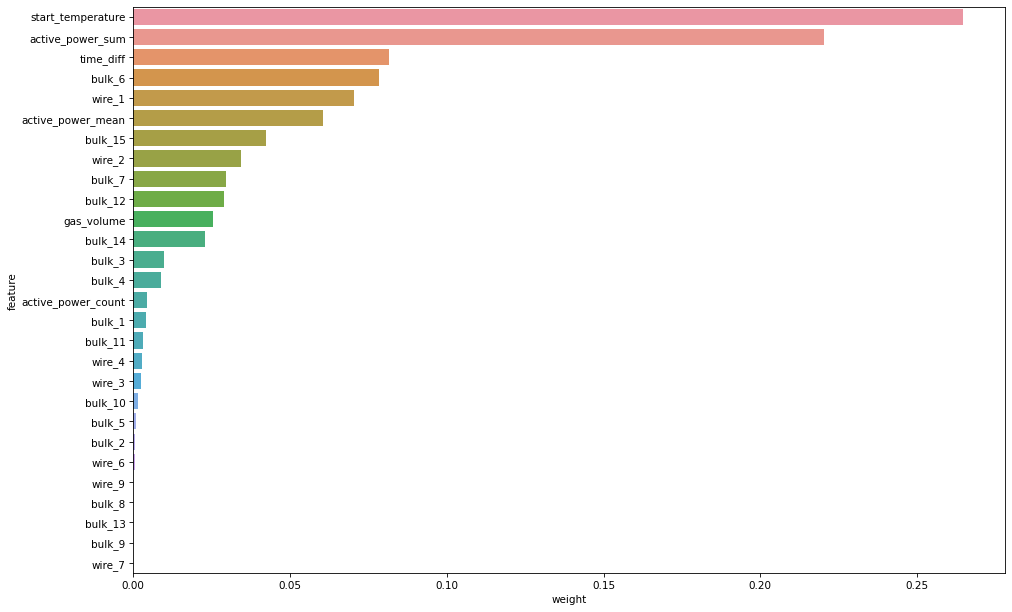

<p class="lead">Из данной диаграммы видно, что значение примерно половины признаков для нашей модели минимальное, ввиду чего эти данные можно было бы не учитывать при обучении, что упростило бы модель и сделало бы её более интерпретируемой. 
<p class="lead">Учитывая вышеуказанный вывод, мы обучили еще одну модель Случайного леса на данных, в которых были удалены столбцы с признаками, оказывающими низкое влияние на предсказания модели. Показания метрики этой модели оказались практически такими же, как у модели, обученной на полном наборе данных, но модель с меньшим количеством признаков является более предпочтительной, так как её проще интерпретировать.
<p class="lead">Признаками, оказывающими наибольшее влияние на итоговую модель, являются начальная температура, суммарное количество активной энергии, разница во времени между первым и последним замером, количество добавки bulk_15, а также среднее количество активной энергии. Вклад данных признаков в предсказание модели составяет 70.5%.
<p class="lead">Понимание тех признаков, которые оказывают наибольшее влияние на модель, позволяит более осознано подходить к вопросу управления целевым признанаком - конечной температурой стали.